In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import Markdown, display, Video
from io import BytesIO
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

assesment_draw_and_fill = True

# Fully Connected Neural Networks

In this assesment we will work on some of the most popular improvements of neural networks, using as a base model the fully connected Neural Networks.

Fully connected Neural Network are function approximators build up from computational graphs whose basic building blocks are a linear operation implemented through a matrix multiplication, and a non-linear element-wise activation function.

Mathematically we have:

$$
\begin{split}
z_1 &= (x^T W^1)^T + b^1\\
h_1 &= \phi(z_1)\\
---&---------- \text{ proyection to layer 1}\\
%
z_2 &= (h_1^T W^2)^T + b^2\\
h_2 &= \phi(z_2)\\
---&---------- \text{ proyection to layer 2}\\
%
&\,\,\vdots\\
%
z_o &= (h_{l-1}^T W^{l})^T + b^{l}\\
y &= \Phi(z_o)\\
---&---------- \text{ proyection to output layer}\\
\end{split}
$$

where $\phi$ denotes the hidden layer element-wise activation function, $\Phi$ the link function and $W$ and $b$ the parameters of the linear projection.

Element-wise functions are functions that (though not being defined mathematically as such) are very popular in computer science, in the same way as broadcasting operations.

An element-wise function $f: \mathbb{R}^N \rightarrow \mathbb{R}^N$ is build up by applying a scalar-valued function $g: \mathbb{R} \rightarrow \mathbb{R}$ to each of the dimensions in the domain of $f$, such that a specific dimension in the range of $f$ only depends on the corresponding dimension in the domain. For example the ReLU function:

$$
\text{ReLU}(x) = \begin{cases}x, \, x >0 \\ 0\end{cases}
$$

can be used to construct and element-wise function. The result when applied to some element in $\mathbb{R^N}$ or any element from a product space of $\mathbb{R^N}$  would be:

$$
f\left(\begin{pmatrix}1 & -2 & 3\\
3 & -4 & -2
\end{pmatrix}\right) = \begin{pmatrix}1 & 0 & 3\\
3 & 0 & 0
\end{pmatrix}
$$

Why are we interested in element-wise activation functions? Well one of their reasons is that the Jacobian computation is a diagonal matrix, and so simplifies vector-Jacobian computations in automatic differentiation, see the advanced section there.

One of the cool things about neural networks is that the way we construct these networks imply functions belonging to different subsets of a function space $\mathcal{F}$. Yet I am not sure (though it has been probably done already in the literature) there are possible ways to select our network architecture so that the functions appearing are always subsets from, e.g. an $L^2$ space. In fact, one hidden layer neural network with tanh activation function and an infinite number of neurons is a Gaussian Process with squared exponential kernel. This generalization of the infinite limit has already been done for other model's such as convolutional neural networks.

Let's simulate this behaviour and see how different activation functions allow us to construct different types of functions.

## 1. Visualizing Function spaces induced by activation functions.

##### Task 1.1
Create an `nn.Module` that implements a Deep Neural Network with a fully connected structure. You will be then completing this initial code adding different features such as dropout or batch normalization.

Your class should have the following structure, where we will use a FC layer nn module and a Neural Network module.

```python
def linear_link(x):
    return x
    
class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act):
        super().__init__()
        ...
        
    def forward(self, x):
        ...

class FCDNN(nn.Module):
    def __init__(self, dim_in:int, dim_out:int, neurons_hidden : list, hidden_activations:list, link_function, loss_function):
        super().__init__()
        ...
        
    def forward(self,x, apply_link):
        ...

    def compute_loss(self,t,y):
        ...

```

In [ ]:
if assesment_draw_and_fill:
    code = """```python
def linear_link(x):
    return x

class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act):
        super().__init__()
        ## create parameters
        self.linear = ...
        self.act = ...

    def forward(self, x):
        fx = ...
        return fx


class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, link_function, loss_function):
        super().__init__()

        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act in zip(neurons_hidden, hidden_activations):
            module_list.append(...)
            dim_in = num_neur

        # output layer
        o_layer = ...
        module_list.append(o_layer)

        self.layers = module_list

        ## Loss and link function
        self.link = ...
        self.loss = ...

    def forward(self,x, apply_link):
        for l in self.layers:
            ...

        y = x
        if apply_link:
            y = self.link(y)

        return y

    def compute_loss(self,t,y):
        return ...
```"""
    display(Markdown(code))

```python
def linear_link(x):
    return x
    
class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act):
        super().__init__()
        ## create parameters
        self.linear = ...
        self.act = ...
        
    def forward(self, x):
        fx = ...
        return fx


class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, dropout_hidden, batch_norm: bool, add_residual:bool, link_function, loss_function):
        super().__init__()

        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):
            module_list.append(...)
            dim_in = num_neur

        # output layer
        o_layer = ...
        module_list.append(o_layer)

        self.layers = module_list
       
        ## Loss and link function
        self.link = ...
        self.loss = ...
        
    def forward(self,x, apply_link):
        for l in self.layers:
            ...
            
        y = x
        if apply_link:
            y = self.link(y)
        
        return y

    def compute_loss(self,t,y):
        return ...
```

In [5]:
def linear_link(x):
    return x

class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act, drop, batch_norm, add_residual):
        super().__init__()
        ## create parameters
        self.linear = nn.Linear(dim_in, dim_out)
        self.act = act
        self.drop = nn.Dropout(p = drop)
        if batch_norm:
            self.bn = nn.BatchNorm1d(dim_out)
        else:
            self.bn = linear_link

        self.add_residual = add_residual
        # when residual is needed we need to readapt input
        if add_residual and dim_in != dim_out:
            self.bottleneck = nn.Linear(dim_in,dim_out)
        else:
            self.bottleneck = linear_link

        self.traced_grads = {}

    def forward(self, x):
        fx = self.drop(self.act(self.bn(self.linear(x))))
        if self.add_residual:
            fx = self.bottleneck(x) + fx
        return fx

    def trace_gradients(self):
        for k, v in self.named_parameters():
            if k in self.traced_grads.keys():
                self.traced_grads[k].append( v.grad.data.clone() )
            else:
                self.traced_grads[k] = [v.grad.data.clone()]

    def reset_traced_grads(self):
        self.traced_grads = {}

    def get_traced_grads(self):
        return self.traced_grads

class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, dropout_hidden, batch_norm: bool, add_residual:bool, link_function, loss_function):
        super().__init__()

        assert len(neurons_hidden) == len(hidden_activations), "List specifying hidden activations and number of hidden layers must coincide"
        assert len(neurons_hidden) == len(dropout_hidden), "List specifying hidden activations and dropout per layer"


        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):
            module_list.append(FCLayer(dim_in, num_neur, act, drop, batch_norm, add_residual))
            dim_in = num_neur

        # output layer
        o_layer = FCLayer(dim_in, dim_out, act = linear_link, drop = 0.0, batch_norm = False, add_residual = False)
        module_list.append(o_layer)

        self.layers = module_list

        ## Loss and link function
        self.link = link_function
        self.loss = loss_function

    def forward_train(self,x, apply_link):
        self.train()

        for l in self.layers:
            x = l(x)
        y = x
        if apply_link:
            y = self.link(y)

        return y

    def forward_eval(self,x, apply_link):
        self.eval()

        for l in self.layers:
            x = l(x)
        y = x
        if apply_link:
            y = self.link(y)

        return y

    def compute_loss(self,t,y):
        return self.loss(y,t)

    def get_internal_representations(self, x, apply_link):
        internals = {}
        # exclude output layer projection since this method gets internal representations
        for i, l in enumerate(self.layers[:-1]):
            x = l(x)
            internals[f'layer {i+1}']= x
        return internals

    def trace_gradients(self):
        for l in self.layers:
            l.trace_gradients()

    def reset_traced_grads(self):
        for l in self.layers:
            l.reset_traced_grads()

    def get_traced_grads(self):
        traced_grads = {}
        for i,l in enumerate(self.layers):
            traced_grads[f'layer {i+1}'] = l.get_traced_grads()

        return traced_grads

##### Task 1.2
Visualize different space of functions $f:\mathbb{R} \rightarrow \mathbb{R}$ constructed by different architectures. Try different activations: sigmoid, relu and tanh, with different number of hidden layers and different number of neurons per layer.

In [ ]:
if assesment_draw_and_fill:
    code = """```python
## function domain
N_min = -10
N_max = 10
N_points = 100

x_range = torch.linspace(..., ..., N_points).reshape(N_points, 1)

## num functions to display
N_fun = ...

## Lets parameterize different models
activations = {
                'sigmoid' : ...,
                'relu' : ...,
                'tanh' : ...
              }
num_hidden_layers = [...]
neurons_per_layer = [...]# [2,10,128,512,1024]

## create figure grid
fig, axes = plt.subplots(len(activations), len(num_hidden_layers) * len(neurons_per_layer), figsize = (200,80))

for i_a, (act_n, act_p) in enumerate(activations.items()):
    ax_acts = axes[i_a]

    counter_ax = 0
    for i_h, num_h in enumerate(num_hidden_layers):
        for i_n, n_l in enumerate(neurons_per_layer):
            ax_neur = ax_acts[counter_ax]

            for n_fun in range(N_fun):
                model = FCDNN(
                              dim_in = ...,
                              dim_out = ...,
                              neurons_hidden = [...]*num_h,
                              hidden_activations = [...]*num_h,
                              link_function = linear_link,
                              loss_function = None
                             )

                with torch.no_grad():
                    y_range = model.forward(x_range, apply_link = True)

                    ax_neur.plot(x_range, y_range, color = f'C{n_fun}', linewidth = 15)

            if counter_ax == 0:
                ax_neur.set_ylabel(f'{act_n}', fontsize = 80)

            ax_neur.set_title(f'hidden layers {num_h} \n neurons : {n_l}', fontsize = 80)
            ax_neur.tick_params(axis='both', labelsize=60)

            counter_ax += 1
```"""
    display(Markdown(code))

```python
## function domain
N_min = -10
N_max = 10
N_points = 100

x_range = torch.linspace(..., ..., N_points).reshape(N_points, 1)

## num functions to display
N_fun = ...

## Lets parameterize different models
activations = {
                'sigmoid' : ..., 
                'relu' : ..., 
                'tanh' : ...
              }
num_hidden_layers = [...]
neurons_per_layer = [...]# [2,10,128,512,1024]

## create figure grid
fig, axes = plt.subplots(len(activations), len(num_hidden_layers) * len(neurons_per_layer), figsize = (200,80))

for i_a, (act_n, act_p) in enumerate(activations.items()):
    ax_acts = axes[i_a]
    
    counter_ax = 0
    for i_h, num_h in enumerate(num_hidden_layers):
        for i_n, n_l in enumerate(neurons_per_layer):
            ax_neur = ax_acts[counter_ax]
            
            for n_fun in range(N_fun):
                model = FCDNN(
                              dim_in = ..., 
                              dim_out = ..., 
                              neurons_hidden = [...]*num_h, 
                              hidden_activations = [...]*num_h,
                              link_function = linear_link, 
                              loss_function = None
                             )

                with torch.no_grad():
                    y_range = model.forward(x_range, apply_link = True)

                    ax_neur.plot(x_range, y_range, color = f'C{n_fun}', linewidth = 15)
            
            if counter_ax == 0:
                ax_neur.set_ylabel(f'{act_n}', fontsize = 80)
            
            ax_neur.set_title(f'hidden layers {num_h} 
 neurons : {n_l}', fontsize = 80)
            ax_neur.tick_params(axis='both', labelsize=60)
            
            counter_ax += 1
```

In [ ]:
## function domain
N_min = -10
N_max = 10
N_points = 100

x_range = torch.linspace(N_min, N_max, N_points).reshape(N_points, 1)

## num functions to display
N_fun = 10

## Lets parameterize different models
activations = {
                'sigmoid' : torch.sigmoid,
                'relu' : torch.relu,
                'tanh' : torch.tanh
              }
num_hidden_layers = [1, 2, 3]
neurons_per_layer = [2, 10, 1024]# [2,10,128,512,1024]

## create figure grid
fig, axes = plt.subplots(len(activations), len(num_hidden_layers) * len(neurons_per_layer), figsize = (200,80))

for i_a, (act_n, act_p) in enumerate(activations.items()):
    ax_acts = axes[i_a]

    counter_ax = 0
    for i_h, num_h in enumerate(num_hidden_layers):
        for i_n, n_l in enumerate(neurons_per_layer):
            ax_neur = ax_acts[counter_ax]

            for n_fun in range(N_fun):
                model = FCDNN(
                              dim_in = 1,
                              dim_out = 1,
                              neurons_hidden = [n_l]*num_h,
                              hidden_activations = [act_p]*num_h,
                              dropout_hidden = [0.0]*num_h,
                              batch_norm = False,
                              add_residual = False,
                              link_function = linear_link,
                              loss_function = None
                             )

                with torch.no_grad():
                    y_range = model.forward_eval(x_range, apply_link = True)

                    ax_neur.plot(x_range, y_range, color = f'C{n_fun}', linewidth = 15)

            if counter_ax == 0:
                ax_neur.set_ylabel(f'{act_n}', fontsize = 80)

            ax_neur.set_title(f'hidden layers {num_h} \n neurons : {n_l}', fontsize = 80)
            ax_neur.tick_params(axis='both', labelsize=60)

            counter_ax += 1


##### Task 1.3
Visualize different space of functions $f:\mathbb{R}^2 \rightarrow [0,1]$ constructed by different architectures. Try different activations: sigmoid, relu and tanh, with different number of hidden layers and different number of neurons per layer.

In [ ]:
if assesment_draw_and_fill:
    code = """```python
## function domain
N_min = -10
N_max = 10
N_points_domain = 30
thr_prob = 0.5 # use to plot our classification guess
x1, x2 = np.meshgrid(np.linspace(N_min,N_max,N_points_domain, dtype = np.float32),np.linspace(N_min,N_max,N_points_domain, dtype = np.float32))

# reshape for neural network
x_range = torch.from_numpy(
    np.hstack((np.reshape(x1, (N_points_domain**2,1)),np.reshape(x2, (N_points_domain**2,1))))
).float()

# allocate memory to plot decision thresholds
y_range_plot = np.zeros((N_points_domain,N_points_domain), np.float32)

# class colors
color_c0 = 'C0'
color_c1 = 'C1'

## num functions to display
N_fun = 20

## Lets parameterize different models
activations = {
                'sigmoid' : ...,
                'relu' : ...,
                'tanh' : ...
              }
num_hidden_layers = [...]
neurons_per_layer = [...]

## create figure grid and video wrapper
fig, axes = plt.subplots(len(activations), len(num_hidden_layers) * len(neurons_per_layer), figsize = (12,4.8))
plt.subplots_adjust(hspace=0.6)

video_filename = "/tmp/aux4.mp4"
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

for n_fun in range(N_fun):
    for i_a, (act_n, act_p) in enumerate(activations.items()):
        ax_acts = axes[i_a]

        counter_ax = 0
        for i_h, num_h in enumerate(num_hidden_layers):
            for i_n, n_l in enumerate(neurons_per_layer):
                ax_neur = ax_acts[counter_ax]
                ax_neur.cla()

                model = FCDNN(
                              dim_in = ...,
                              dim_out = ...,
                              neurons_hidden = [...]*num_h,
                              hidden_activations = [...]*num_h,
                              link_function = ...,
                              loss_function = None
                             )

                with torch.no_grad():

                    ## forward to plot decision thresholds
                    y_range = model.forward(x_range, apply_link = True)

                    # reshape back to plotting
                    y_range = np.reshape(y_range, (N_points_domain,N_points_domain))

                    ## plot prediction probability for class 1 and 0
                    idx_range1 = y_range > thr_prob
                    idx_range0 = ~idx_range1

                    y_range_plot[idx_range1] = y_range[idx_range1]
                    y_range_plot[idx_range0] = np.nan

                    ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)

                    y_range_plot[idx_range0] = y_range[idx_range0]
                    y_range_plot[idx_range1] = np.nan

                    ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)

                    # decision threshold
                    contour1 = ax_neur.contour(x1, x2, y_range, levels = [thr_prob], colors = ["k"])
                    ax_neur.clabel(contour1, inline=True, fontsize=8, fmt="%.2f")

                if counter_ax == 0:
                    ax_neur.set_ylabel(f'{act_n}', fontsize = 15)

                ax_neur.set_title(f'h_lay {num_h} \n neu : {n_l}', fontsize =  5)
                ax_neur.tick_params(axis='both', labelsize=5)

                counter_ax += 1

    ## add frame for video creation
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)

    buf.seek(0)
    frame = imageio.imread(buf)
    writer.append_data(frame)

writer.close()
plt.close()

display(Video(data=video_filename, embed=True))
os.remove(video_filename)
```"""
    display(Markdown(code))

```python
## function domain
N_min = -10
N_max = 10
N_points_domain = 30
thr_prob = 0.5 # use to plot our classification guess
x1, x2 = np.meshgrid(np.linspace(N_min,N_max,N_points_domain, dtype = np.float32),np.linspace(N_min,N_max,N_points_domain, dtype = np.float32))

# reshape for neural network
x_range = torch.from_numpy(
    np.hstack((np.reshape(x1, (N_points_domain**2,1)),np.reshape(x2, (N_points_domain**2,1))))
).float()

# allocate memory to plot decision thresholds
y_range_plot = np.zeros((N_points_domain,N_points_domain), np.float32)

# class colors
color_c0 = 'C0'
color_c1 = 'C1'

## num functions to display
N_fun = 20

## Lets parameterize different models
activations = {
                'sigmoid' : ..., 
                'relu' : ..., 
                'tanh' : ...
              }
num_hidden_layers = [...]
neurons_per_layer = [...]

## create figure grid and video wrapper
fig, axes = plt.subplots(len(activations), len(num_hidden_layers) * len(neurons_per_layer), figsize = (12,4.8))
plt.subplots_adjust(hspace=0.6)

video_filename = "/tmp/aux4.mp4"
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

for n_fun in range(N_fun):
    for i_a, (act_n, act_p) in enumerate(activations.items()):
        ax_acts = axes[i_a]

        counter_ax = 0
        for i_h, num_h in enumerate(num_hidden_layers):
            for i_n, n_l in enumerate(neurons_per_layer):
                ax_neur = ax_acts[counter_ax]
                ax_neur.cla()
            
                model = FCDNN(
                              dim_in = ..., 
                              dim_out = ..., 
                              neurons_hidden = [...]*num_h, 
                              hidden_activations = [...]*num_h,
                              link_function = ..., 
                              loss_function = None
                             )

                with torch.no_grad():

                    ## forward to plot decision thresholds
                    y_range = model.forward(x_range, apply_link = True)

                    # reshape back to plotting
                    y_range = np.reshape(y_range, (N_points_domain,N_points_domain))

                    ## plot prediction probability for class 1 and 0
                    idx_range1 = y_range > thr_prob
                    idx_range0 = ~idx_range1

                    y_range_plot[idx_range1] = y_range[idx_range1]
                    y_range_plot[idx_range0] = np.nan

                    ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
   
                    y_range_plot[idx_range0] = y_range[idx_range0]
                    y_range_plot[idx_range1] = np.nan

                    ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)
            
                    # decision threshold
                    contour1 = ax_neur.contour(x1, x2, y_range, levels = [thr_prob], colors = ["k"])
                    ax_neur.clabel(contour1, inline=True, fontsize=8, fmt="%.2f")
            
                if counter_ax == 0:
                    ax_neur.set_ylabel(f'{act_n}', fontsize = 15)

                ax_neur.set_title(f'h_lay {num_h} 
 neu : {n_l}', fontsize =  5)
                ax_neur.tick_params(axis='both', labelsize=5)

                counter_ax += 1
                  
    ## add frame for video creation
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)

    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 

writer.close()
plt.close()

display(Video(data=video_filename, embed=True))
os.remove(video_filename)
```

In [ ]:
## function domain
N_min = -10
N_max = 10
N_points_domain = 30
thr_prob = 0.5 # use to plot our classification guess
x1, x2 = np.meshgrid(np.linspace(N_min,N_max,N_points_domain, dtype = np.float32),np.linspace(N_min,N_max,N_points_domain, dtype = np.float32))

# reshape for neural network
x_range = torch.from_numpy(
    np.hstack((np.reshape(x1, (N_points_domain**2,1)),np.reshape(x2, (N_points_domain**2,1))))
).float()

# allocate memory to plot decision thresholds
y_range_plot = np.zeros((N_points_domain,N_points_domain), np.float32)

# class colors
color_c0 = 'C0'
color_c1 = 'C1'

## num functions to display
N_fun = 20

## Lets parameterize different models
activations = {
                'sigmoid' : torch.sigmoid,
                'relu' : torch.relu,
                'tanh' : torch.tanh
              }
num_hidden_layers = [1,2,3]
neurons_per_layer = [2,10,128,512,1024]

## create figure grid and video wrapper
fig, axes = plt.subplots(len(activations), len(num_hidden_layers) * len(neurons_per_layer), figsize = (12,4.8))
plt.subplots_adjust(hspace=0.6)

video_filename = "/tmp/aux4.mp4"
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

for n_fun in range(N_fun):
    for i_a, (act_n, act_p) in enumerate(activations.items()):
        ax_acts = axes[i_a]

        counter_ax = 0
        for i_h, num_h in enumerate(num_hidden_layers):
            for i_n, n_l in enumerate(neurons_per_layer):
                ax_neur = ax_acts[counter_ax]
                ax_neur.cla()

                model = FCDNN(
                              dim_in = 2,
                              dim_out = 1,
                              neurons_hidden = [n_l]*num_h,
                              hidden_activations = [act_p]*num_h,
                              dropout_hidden = [0.0]*num_h,
                              batch_norm = False,
                              add_residual = False,
                              link_function = torch.sigmoid,
                              loss_function = None
                             )

                with torch.no_grad():

                    ## forward to plot decision thresholds
                    y_range = model.forward_eval(x_range, apply_link = True)

                    # reshape back to plotting
                    y_range = np.reshape(y_range, (N_points_domain,N_points_domain))

                    ## plot prediction probability for class 1 and 0
                    idx_range1 = y_range > thr_prob
                    idx_range0 = ~idx_range1

                    y_range_plot[idx_range1] = y_range[idx_range1]
                    y_range_plot[idx_range0] = np.nan

                    ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)

                    y_range_plot[idx_range0] = y_range[idx_range0]
                    y_range_plot[idx_range1] = np.nan

                    ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)

                    # decision threshold
                    contour1 = ax_neur.contour(x1, x2, y_range, levels = [thr_prob], colors = ["k"])
                    ax_neur.clabel(contour1, inline=True, fontsize=8, fmt="%.2f")

                if counter_ax == 0:
                    ax_neur.set_ylabel(f'{act_n}', fontsize = 15)

                ax_neur.set_title(f'h_lay {num_h} \n neu : {n_l}', fontsize =  5)
                ax_neur.tick_params(axis='both', labelsize=5)

                counter_ax += 1

    ## add frame for video creation
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)

    buf.seek(0)
    frame = imageio.imread(buf)
    writer.append_data(frame)

writer.close()
plt.close()

/tmp/ipykernel_554265/1526956548.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
/tmp/ipykernel_554265/1526956548.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax_neur.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)


In [ ]:
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

## 2 Training Neural Networks on the MNIST

Let's start creating neural networks that go beyond some toy easy to visualize problems. To do so we will work on the MNIST classification problem. The MNIST classification problem consists of $28 \times 28$ gray scale images, that we want to classify into $10$ classes.



##### Task 2.0.0: Preparing your data

Create three mnist dataloaders with the following characteristics:

* train_loader:  batch_size 100, shuffle True.
* train_laoder_eval: batch_size 1000, shuffle False.
* test_loader: batch_size 1000, shuffle false.

The mnist dataset is available in the torchvision package: `https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html`

Note that we will use a transformation that will reshape 28x28 images into vectors of 784 dimensions, to allow computations through fully connected layers.

In [ ]:
if assesment_draw_and_fill:
    code = """```python
## =========================== ##
## Data Pipeline configuration ##
## =========================== ##

## Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Train dataset
train_dataset = torchvision.datasets.MNIST(root='/tmp/data', train=..., transform=..., download=True)

# Test dataset
test_dataset = torchvision.datasets.MNIST(root='/tmp/data', train=..., transform=..., download=True)

# Train and test loaders
train_loader = torch.utils.data.DataLoader(..., shuffle=True)
train_loader_eval = torch.utils.data.DataLoader(..., shuffle=False)
test_loader = torch.utils.data.DataLoader(..., shuffle=False)

## Data stats
N_training = len(train_dataset)
N_test = len(test_dataset)

```"""
    display(Markdown(code))

```python
## =========================== ##
## Data Pipeline configuration ##
## =========================== ##

## Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)) 
])

# Train dataset
train_dataset = torchvision.datasets.MNIST(root='/tmp/data', train=..., transform=..., download=True)

# Test dataset
test_dataset = torchvision.datasets.MNIST(root='/tmp/data', train=..., transform=..., download=True)

# Train and test loaders
train_loader = torch.utils.data.DataLoader(..., shuffle=True)
train_loader_eval = torch.utils.data.DataLoader(..., shuffle=False)
test_loader = torch.utils.data.DataLoader(..., shuffle=False)

## Data stats
N_training = len(train_dataset)
N_test = len(test_dataset)

```

In [6]:
## =========================== ##
## Data Pipeline configuration ##
## =========================== ##

## Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Train dataset
train_dataset = torchvision.datasets.MNIST(root='/tmp/data', train=True, transform=transform, download=True)

# Test dataset
test_dataset = torchvision.datasets.MNIST(root='/tmp/data', train=False, transform=transform, download=True)

# Train and test loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
train_loader_eval = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Data stats
N_training = len(train_dataset)
N_test = len(test_dataset)


100%|██████████| 9.91M/9.91M [00:00<00:00, 165MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 22.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 86.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


##### Task 2.0.1

Fill in the following specifications of your model, i.e the Neural Network that we will use to classify MNIST images:

* number of input neurons: ...
* number of output neurons: ...
* link function: ...

##### Task 2.0.2

Let's create an evaluation function. Since MNIST is a balanced classification problem, we will measure how good the network performs using de accuracy. The accuracy is easy to compute. Since our networks outputs a softmax function which provides the probability of the input belonging to each of the classes, we will select the class corresponding to the highest probability.

To do so you can use the `argmax` function from pytorch or numpy. This function will provide the position in the vector where the maximum occurs, and so you can compare this value to the actual label.

Create this evaluation function. This function will receive a dataloader and the model, will iterate over the dataloader and will compute the accuracy, returning this value.

In [ ]:
if assesment_draw_and_fill:
    code = """```python
def compute_metric(dataloader, model):
    acc = 0.0
    tot_samples = 0
    for x,t in dataloader:
        ## move data to device and reshape
        x, t = x.to(device), t.to(device)

        ## forward no need to apply link since softmax is monotically increasing
        y = ...

        ## compute number of correct samples
        acc += ...

        ## accumulate total number of samples
        tot_samples += len(t)

    return acc / tot_samples

```"""
    display(Markdown(code))

```python
def compute_metric(dataloader, model):
    acc = 0.0
    tot_samples = 0
    for x,t in dataloader:
        ## move data to device and reshape
        x, t = x.to(device), t.to(device)

        ## forward no need to apply link since softmax is monotically increasing
        y = ...

        ## compute number of correct samples
        acc += ...

        ## accumulate total number of samples
        tot_samples += len(t)
        
    return acc / tot_samples

```

In [6]:
def compute_metric(dataloader, model):
    acc = 0.0
    tot_samples = 0
    for x,t in dataloader:
        ## move data to device and reshape
        x, t = x.to(device), t.to(device)

        ## forward no need to apply link since softmax is monotically increasing
        y = model.forward_eval(x, apply_link = False)

        ## compute number of correct samples
        acc += (t == torch.argmax(y, dim = 1)).sum()

        ## accumulate total number of samples
        tot_samples += len(t)

    return acc / tot_samples

##### Task 2.0.3

Before training the different networks, let's create a utility function that we can reuse to train and evaluate the different models we are going to try.

The utility function will have the following structure:

```python
def test_model(
    model : torch.nn.Module,
    epochs : int,  
    train_batch_size : int,
    lr : float,
    mmu : float,
    apply_scheduler : bool,
    eval_each : int,
    train_dataset : torchvision.datasets,  
    test_dataset : torchvision.datasets
):
```

This utility function will have to:

* receive an instance of the fully connected neural network we want to try.
* receive the number of epochs, training_batch_size, learning_rate and momentum parameter. A boolean specifying whether learning rate scheduling is applied. An integer specifying how many epochs should be run before triggering evaluation, and the train and test datasets.
* instance three dataloaders, one for training and two for evaluating the training and test sets. These last ones should use a batch size of 1000, while the training one should use train_batch_size.
* instance the optimizer (use SGD with momentum = mmu and lr = lr)
* run optimization over the epochs passed in as argument.
* each evalu_each epochs evaluate the model computing the accuracy.
* return three lists: loss_epochs, train_acc_epochs, test_acc_epochs with the loss training accuracy and test accuracy over the course of learning.

When calling the function we will be passing in the model instance we want to try, so that by calling just one function we can easily test different model configurations.

In [ ]:
if assesment_draw_and_fill:
    code = """```python

def test_model(
    model : torch.nn.Module,
    epochs : int,
    train_batch_size : int,
    lr : float,
    mmu : float,
    apply_scheduler : bool,
    eval_each : int,
    train_dataset : torchvision.datasets,
    test_dataset : torchvision.datasets
):

    ## Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # Train and test loaders
    train_loader = torch.utils.data.DataLoader(..., shuffle=True)
    train_loader_eval = torch.utils.data.DataLoader(..., shuffle=False)
    test_loader = torch.utils.data.DataLoader(..., shuffle=False)

    ## Data stats
    N_training = len(train_dataset)
    N_test = len(test_dataset)

    ## =============================== ##
    ## Compute stats at initialization ##
    ## =============================== ##
    ## Variables to monitor things
    loss_epochs = []
    train_acc_epochs = []
    test_acc_epochs = []

    with torch.no_grad():
        ## Compute cross entropy loss at initialization.
        loss_acc = 0.0
        for batch_idx, (x,t) in enumerate(train_loader_eval):

            ## move data to device and reshape
            x, t = x.to(device), t.to(device)

            ## forward
            y = model.forward(...)
            L = model.compute_loss(...)
            loss_acc += len(x)*L.item()

        ## compute accuracies per sample
        train_acc = compute_metric(...,...)
        test_acc = compute_metric(...,...)

    loss_epochs.append(loss_acc/N_training)
    train_acc_epochs.append(...)
    test_acc_epochs.append(...)

    ## ================= ##
    ## Training Pipeline ##
    ## ================= ##
    optimizer = ...
    ## [20,80] or [10]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [10], gamma=0.1)

    for e in range(epochs):
        loss_acc = 0.0
        for batch_idx, (x,t) in enumerate(...):

            ## move data to device and reshape
            x, t = x.to(device), t.to(device)

            ## forward
            y = model.forward(...)
            L = model.compute_loss(...)
            loss_acc += len(x)*L.item()

            ## backward
            ...

            ## Optimizer step
            ...

            ## Optimizer zero grad
            ...

            ## loss per batch
            print(f"On epoch {e+1} batch_idx {batch_idx + 1} got loss {L.item():.5f}", end = "\r")

        ## learning rate scheduling.
        if apply_scheduler:
            scheduler.step()

        ## Evaluate model and draw plots using threads to speed up computations.
        if (e + 1) % eval_each == 0 or e == 0:
            with torch.no_grad():

                ## compute accuracies per sample
                train_acc = ...
                test_acc = ...

            ## total loss on training set
            print(" "*200, end="\r")
            print(f"On epoch {e+1} got loss {loss_acc/N_training:.5f} with train accuracy {train_acc:.5f} and test accuracy {test_acc:.5f}")

        else:
            ## total loss on training set
            print(" "*200, end="\r")
            print(f"On epoch {e+1} got loss {loss_acc/N_training:.5f}")

        loss_epochs.append(loss_acc/N_training)
        train_acc_epochs.append(...)
        test_acc_epochs.append(...)

    return loss_epochs, train_acc_epochs, test_acc_epochs

```"""
    display(Markdown(code))

```python

def test_model(
    model : torch.nn.Module, 
    epochs : int,  
    train_batch_size : int, 
    lr : float, 
    mmu : float, 
    apply_scheduler : bool, 
    eval_each : int, 
    train_dataset : torchvision.datasets,  
    test_dataset : torchvision.datasets
):
    
    ## Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)) 
    ])

    # Train and test loaders
    train_loader = torch.utils.data.DataLoader(..., shuffle=True)
    train_loader_eval = torch.utils.data.DataLoader(..., shuffle=False)
    test_loader = torch.utils.data.DataLoader(..., shuffle=False)

    ## Data stats
    N_training = len(train_dataset)
    N_test = len(test_dataset)

    ## =============================== ##
    ## Compute stats at initialization ##
    ## =============================== ##
    ## Variables to monitor things
    loss_epochs = []
    train_acc_epochs = []
    test_acc_epochs = []
    
    with torch.no_grad():
        ## Compute cross entropy loss at initialization.
        loss_acc = 0.0
        for batch_idx, (x,t) in enumerate(train_loader_eval):
                
            ## move data to device and reshape
            x, t = x.to(device), t.to(device)
            
            ## forward
            y = model.forward(...)
            L = model.compute_loss(...)
            loss_acc += len(x)*L.item()
                    
        ## compute accuracies per sample
        train_acc = compute_metric(...,...)
        test_acc = compute_metric(...,...)

    loss_epochs.append(loss_acc/N_training)
    train_acc_epochs.append(...)
    test_acc_epochs.append(...)
    
    ## ================= ##
    ## Training Pipeline ##
    ## ================= ##
    optimizer = ...
    ## [20,80] or [10]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [10], gamma=0.1)
    
    for e in range(epochs):
        loss_acc = 0.0
        for batch_idx, (x,t) in enumerate(...):
            
            ## move data to device and reshape
            x, t = x.to(device), t.to(device)
           
            ## forward
            y = model.forward(...)
            L = model.compute_loss(...)
            loss_acc += len(x)*L.item()
            
            ## backward
            ...
            
            ## Optimizer step
            ...
            
            ## Optimizer zero grad
            ...
            
            ## loss per batch
            print(f"On epoch {e+1} batch_idx {batch_idx + 1} got loss {L.item():.5f}", end = "")

        ## learning rate scheduling.
        if apply_scheduler:
            scheduler.step()
        
        ## Evaluate model and draw plots using threads to speed up computations.
        if (e + 1) % eval_each == 0 or e == 0:
            with torch.no_grad():
                
                ## compute accuracies per sample
                train_acc = ...
                test_acc = ...
    
            ## total loss on training set
            print(" "*200, end="")
            print(f"On epoch {e+1} got loss {loss_acc/N_training:.5f} with train accuracy {train_acc:.5f} and test accuracy {test_acc:.5f}")
         
        else:
            ## total loss on training set
            print(" "*200, end="")
            print(f"On epoch {e+1} got loss {loss_acc/N_training:.5f}")

        loss_epochs.append(loss_acc/N_training)
        train_acc_epochs.append(...)
        test_acc_epochs.append(...)

    return loss_epochs, train_acc_epochs, test_acc_epochs

```

In [8]:
def test_model(
    model : torch.nn.Module,
    epochs : int,
    train_batch_size : int,
    lr : float,
    mmu : float,
    apply_scheduler : bool,
    eval_each : int,
    train_dataset : torchvision.datasets,
    test_dataset : torchvision.datasets
):

    ## Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # Train and test loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    train_loader_eval = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

    ## Data stats
    N_training = len(train_dataset)
    N_test = len(test_dataset)

    ## =============================== ##
    ## Compute stats at initialization ##
    ## =============================== ##
    ## Variables to monitor things
    loss_epochs = []
    train_acc_epochs = []
    test_acc_epochs = []

    with torch.no_grad():
        ## Compute cross entropy loss at initialization.
        loss_acc = 0.0
        for batch_idx, (x,t) in enumerate(train_loader_eval):

            ## move data to device and reshape
            x, t = x.to(device), t.to(device)

            ## forward
            y = model.forward_train(x, apply_link = False)
            L = model.compute_loss(t,y)
            loss_acc += len(x)*L.item()

        ## compute accuracies per sample
        train_acc = compute_metric(train_loader_eval, model)
        test_acc = compute_metric(test_loader, model)

    loss_epochs.append(loss_acc/N_training)
    train_acc_epochs.append(train_acc)
    test_acc_epochs.append(test_acc)

    ## ================= ##
    ## Training Pipeline ##
    ## ================= ##
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = mmu)
    ## [20,80] or [10], [20,60]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [20,80], gamma=0.1)

    for e in range(epochs):
        loss_acc = 0.0
        for batch_idx, (x,t) in enumerate(train_loader):

            ## move data to device and reshape
            x, t = x.to(device), t.to(device)

            ## forward
            y = model.forward_train(x, apply_link = False)
            L = model.compute_loss(t,y)
            loss_acc += len(x)*L.item()

            ## backward
            L.backward()

            ## Optimizer step
            optimizer.step()

            ## Optimizer zero grad
            optimizer.zero_grad()

            ## loss per batch
            print(f"On epoch {e+1} batch_idx {batch_idx + 1} got loss {L.item():.5f}", end = "\r")

        ## learning rate scheduling.
        if apply_scheduler:
            scheduler.step()

        ## Evaluate model and draw plots using threads to speed up computations.
        if (e + 1) % eval_each == 0 or e == 0:
            with torch.no_grad():

                ## compute accuracies per sample
                train_acc = compute_metric(train_loader_eval, model)
                test_acc = compute_metric(test_loader, model)

            ## total loss on training set
            print(" "*200, end="\r")
            print(f"On epoch {e+1} got loss {loss_acc/N_training:.5f} with train accuracy {train_acc:.5f} and test accuracy {test_acc:.5f}")

        else:
            ## total loss on training set
            print(" "*200, end="\r")
            print(f"On epoch {e+1} got loss {loss_acc/N_training:.5f}")

        loss_epochs.append(loss_acc/N_training)
        train_acc_epochs.append(train_acc)
        test_acc_epochs.append(test_acc)

    return loss_epochs, train_acc_epochs, test_acc_epochs

### 2.1 The effect optimization: Gradient Descent, Stochastic Gradient Descent, Momentum, Learning rate scheduling and loss oscilation.


We will see the differences now between using momentum, stochastic gradients or a bad learning rate which incurs in loss oscilation.

##### NOTE: starting from now remember to add `torch.manual_seed(0)` on the beginning of each cell before executing to guarante reproducible results

#### 2.1.1 Gradient descent vs Stochastic Gradient Descent
Using a 0 hidden layer neural network perform the following tasks.

##### Task: gradient descent

Train a linear model (i.e no hidden layers) using Gradient Descent (train_batch_size = 60000) for 10 epochs, with lr = 0.1 and momentum = 0.9. Capture the output of the return function for later display.

In [ ]:
if assesment_draw_and_fill:
    code = """```python
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = ...
dim_out = ...
model = FCDNN(
              dim_in = ...,
              dim_out = ...,
              neurons_hidden = [],
              hidden_activations = [],
              link_function = ...,
              loss_function = ...,
             )
model.to(device)

gd_loss, gd_train_acc, gd_test_acc = test_model(
    ...,
    epochs = ...,
    train_batch_size = ...,
    lr = ...,
    mmu = ...,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = ...,
    test_dataset = ...

)
```"""
    display(Markdown(code))

```python
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = ...
dim_out = ...
model = FCDNN(
              dim_in = ..., 
              dim_out = ..., 
              neurons_hidden = [], 
              hidden_activations = [],
              link_function = ..., 
              loss_function = ...,
             )
model.to(device)

gd_loss, gd_train_acc, gd_test_acc = test_model(
    ..., 
    epochs = ..., 
    train_batch_size = ..., 
    lr = ..., 
    mmu = ...,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = ...,
    test_dataset = ...
    
)
```

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [],
              hidden_activations = [],
              dropout_hidden = [],
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

gd_loss, gd_train_acc, gd_test_acc = test_model(
    model,
    epochs = 10,
    train_batch_size = 60000,
    lr = 0.1,
    mmu = 0.9,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset

)

On epoch 1 got loss 2.34961 with train accuracy 0.16733 and test accuracy 0.17090                                                                                                                       
On epoch 2 got loss 2.23877 with train accuracy 0.50027 and test accuracy 0.51410                                                                                                                       
On epoch 3 got loss 2.05007 with train accuracy 0.65287 and test accuracy 0.65970                                                                                                                       
On epoch 4 got loss 1.81948 with train accuracy 0.71278 and test accuracy 0.71910                                                                                                                       
On epoch 5 got loss 1.57723 with train accuracy 0.74427 and test accuracy 0.75090                                                                                                                   

##### Task: Stochastic Gradient Descent

Train a linear model (i.e no hidden layers) using Stochastic Gradient Descent (train_batch_size = 100) for 10 epochs, with lr = 0.1 and momentum = 0.9. Capture the output of the return function for later display.

In [ ]:
if assesment_draw_and_fill:
    code = """```python
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = ...
dim_out = ...
model = FCDNN(
              dim_in = ...,
              dim_out = ...,
              neurons_hidden = [],
              hidden_activations = [],
              link_function = ...,
              loss_function = ...,
             )
model.to(device)

sgd_loss, sgd_train_acc, sgd_test_acc = test_model(
    ...,
    epochs = ...,
    train_batch_size = ...,
    lr = ...,
    mmu = ...,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = ...,
    test_dataset = ...

)
```"""
    display(Markdown(code))

```python
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = ...
dim_out = ...
model = FCDNN(
              dim_in = ..., 
              dim_out = ..., 
              neurons_hidden = [], 
              hidden_activations = [],
              link_function = ..., 
              loss_function = ...,
             )
model.to(device)

sgd_loss, sgd_train_acc, sgd_test_acc = test_model(
    ..., 
    epochs = ..., 
    train_batch_size = ..., 
    lr = ..., 
    mmu = ...,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = ...,
    test_dataset = ...
    
)
```

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [],
              hidden_activations = [],
              dropout_hidden = [],
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sgd_loss, sgd_train_acc, sgd_test_acc = test_model(
    model,
    epochs = 10,
    train_batch_size = 100,
    lr = 0.1,
    mmu = 0.9,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.36977 with train accuracy 0.91592 and test accuracy 0.91670                                                                                                                       
On epoch 2 got loss 0.30110 with train accuracy 0.92027 and test accuracy 0.92040                                                                                                                       
On epoch 3 got loss 0.29114 with train accuracy 0.92202 and test accuracy 0.91910                                                                                                                       
On epoch 4 got loss 0.28407 with train accuracy 0.92485 and test accuracy 0.91880                                                                                                                       
On epoch 5 got loss 0.28061 with train accuracy 0.91925 and test accuracy 0.91600                                                                                                                   

##### Task: Visualize comparison

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure of gradient descent and stochastic gradient descent.

In [ ]:
if assesment_draw_and_fill:
    code = """```python
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(..., ...,label = 'gradient descent', color = 'C0')
ax11.plot(..., ...,label = 'stochastic gradient descent', color = 'C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(..., ..., label = 'gradient descent', color = 'C0')
ax21.plot(..., ..., label = 'stochastic gradient descent', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(..., ...,label = 'gradient descent', color = 'C0')
ax31.plot(..., ...,label = 'stochastic gradient descent', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()
```"""
    display(Markdown(code))

```python
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(..., ...,label = 'gradient descent', color = 'C0')
ax11.plot(..., ...,label = 'stochastic gradient descent', color = 'C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(..., ..., label = 'gradient descent', color = 'C0')
ax21.plot(..., ..., label = 'stochastic gradient descent', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(..., ...,label = 'gradient descent', color = 'C0')
ax31.plot(..., ...,label = 'stochastic gradient descent', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()
```

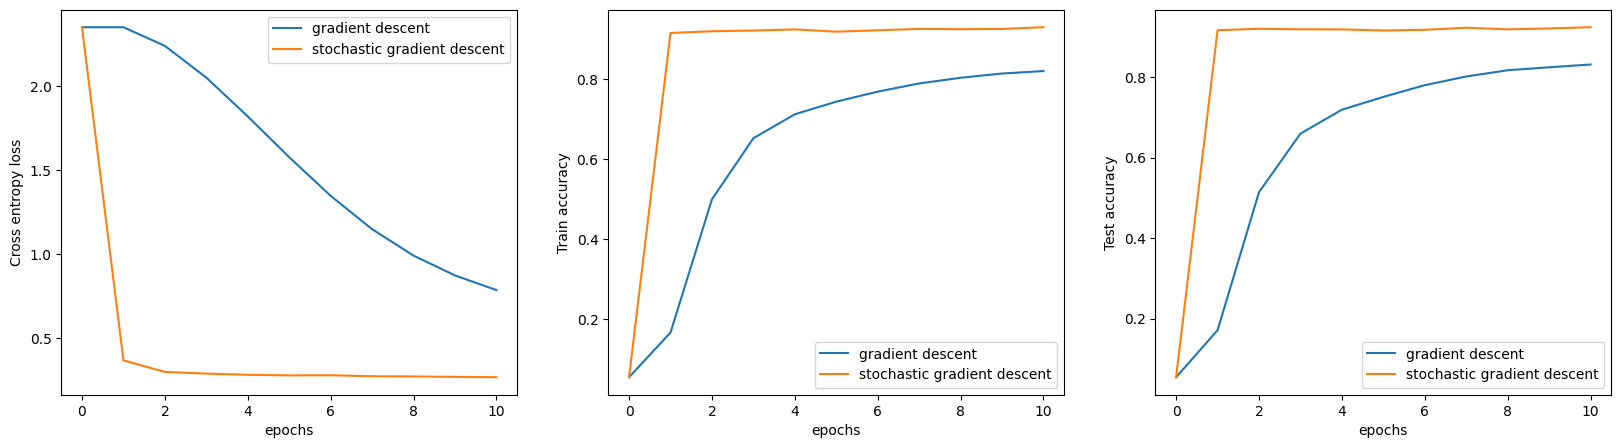

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(gd_loss)), gd_loss,label = 'gradient descent', color = 'C0')
ax11.plot(range(len(sgd_loss)), sgd_loss,label = 'stochastic gradient descent', color = 'C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(gd_train_acc)), gd_train_acc, label = 'gradient descent', color = 'C0')
ax21.plot(range(len(sgd_train_acc)), sgd_train_acc, label = 'stochastic gradient descent', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(gd_test_acc)), gd_test_acc,label = 'gradient descent', color = 'C0')
ax31.plot(range(len(sgd_test_acc)), sgd_test_acc,label = 'stochastic gradient descent', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

#### 2.1.2 The effect of momentum

##### Task: Removing Momentum

Train a model with one hidden layer of 32 neurons, and relu activation, using Stochastic Gradient Descent (train_batch_size = 100) for 10 epochs, with lr = 0.1 and set momentum to 0.0. Capture the output of the return function for later display.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [32],
              hidden_activations = [torch.relu],
              dropout_hidden = [0.0],
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sgd_mmu0_loss, sgd_mmu0_train_acc, sgd_mmu0_test_acc = test_model(
    model,
    epochs = 10,
    train_batch_size = 100,
    lr = 0.1,
    apply_scheduler = False,
    mmu = 0.0,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.55533 with train accuracy 0.90940 and test accuracy 0.91300                                                                                                                       
On epoch 2 got loss 0.28613 with train accuracy 0.92693 and test accuracy 0.92850                                                                                                                       
On epoch 3 got loss 0.24091 with train accuracy 0.93965 and test accuracy 0.93860                                                                                                                       
On epoch 4 got loss 0.20918 with train accuracy 0.94578 and test accuracy 0.94140                                                                                                                       
On epoch 5 got loss 0.18574 with train accuracy 0.95222 and test accuracy 0.95010                                                                                                                   

##### Task:  Training with Momentum

Train the same model using Stochastic Gradient Descent (train_batch_size = 100) for 10 epochs, with lr = 0.1 and set momentum to 0.9

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [32],
              hidden_activations = [torch.relu],
              dropout_hidden = [0.0],
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sgd_mmu09_loss, sgd_mmu09_train_acc, sgd_mmu09_test_acc  = test_model( model,
    epochs = 10,
    train_batch_size = 100,
    lr = 0.1,
    apply_scheduler = False,
    mmu = 0.9,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.31752 with train accuracy 0.94803 and test accuracy 0.94570                                                                                                                       
On epoch 2 got loss 0.15829 with train accuracy 0.96197 and test accuracy 0.95900                                                                                                                       
On epoch 3 got loss 0.12661 with train accuracy 0.97102 and test accuracy 0.96390                                                                                                                       
On epoch 4 got loss 0.11008 with train accuracy 0.97172 and test accuracy 0.96360                                                                                                                       
On epoch 5 got loss 0.10180 with train accuracy 0.96528 and test accuracy 0.95780                                                                                                                   

##### Task

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure of SGD with momentum and no momentum.

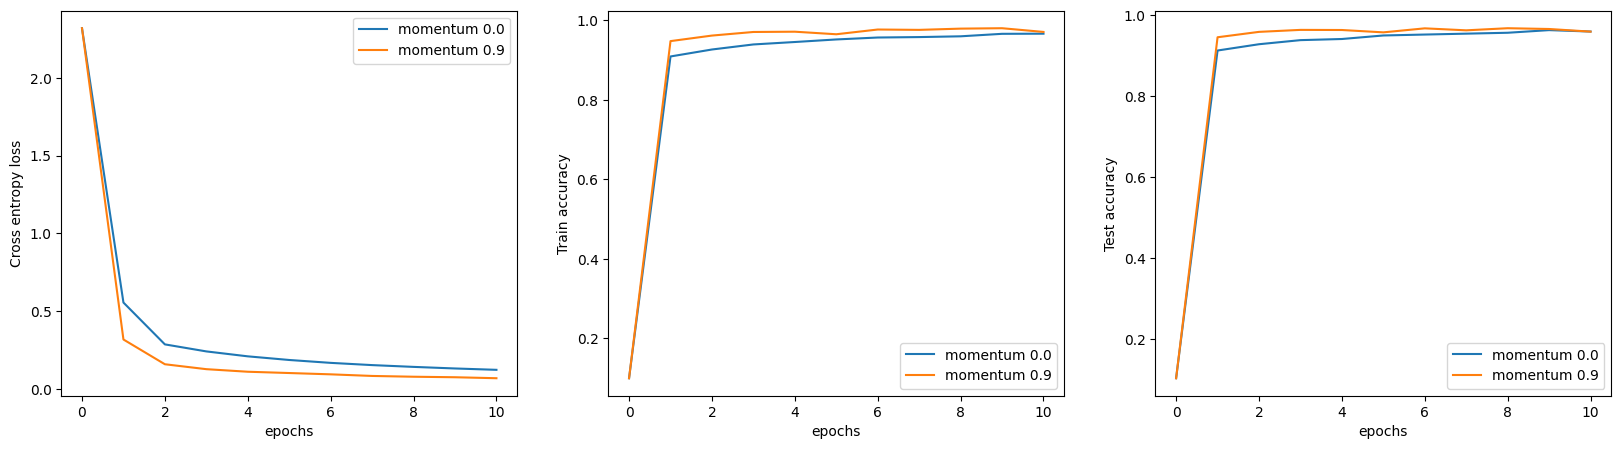

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(sgd_mmu0_loss)), sgd_mmu0_loss,label = 'momentum 0.0', color = 'C0')
ax11.plot(range(len(sgd_mmu09_loss)), sgd_mmu09_loss,label = 'momentum 0.9', color = 'C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(sgd_mmu0_train_acc)), sgd_mmu0_train_acc, label = 'momentum 0.0', color = 'C0')
ax21.plot(range(len(sgd_mmu09_train_acc)), sgd_mmu09_train_acc, label = 'momentum 0.9', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(sgd_mmu0_test_acc)), sgd_mmu0_test_acc,label = 'momentum 0.0', color = 'C0')
ax31.plot(range(len(sgd_mmu09_test_acc)), sgd_mmu09_test_acc,label = 'momentum 0.9', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

#### 2.1.3 The effect of varying the learning rate

##### Task: Oscillating learning rate

Training a zero hidden layer's model with learning rate of 0.99, and momentum of 0.9, with batch size of 100, during 10 epochs. Capture the output of the return function for later display.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [],
              hidden_activations = [],
              dropout_hidden = [],
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sgd_lr09_loss, sgd_lr09_train_acc, sgd_lr09_test_acc = test_model(
    model,
    epochs = 10,
    train_batch_size = 100,
    lr = 0.99,
    apply_scheduler = False,
    mmu = 0.9,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 1.05934 with train accuracy 0.88273 and test accuracy 0.88620                                                                                                                       
On epoch 2 got loss 0.91625                                                                                                                                                                             
On epoch 3 got loss 0.91919                                                                                                                                                                             
On epoch 4 got loss 0.88047                                                                                                                                                                             
On epoch 5 got loss 0.86297                                                                                                                                                                         

##### Task: A good learning rate

Train the same model with learning rate of 0.01. A better learning rate is 0.1. However, for didactic purposes, this one is better.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [],
              hidden_activations = [],
              dropout_hidden = [],
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sgd_lr01_loss, sgd_lr01_train_acc, sgd_lr01_test_acc = test_model(
    model,
    epochs = 10,
    train_batch_size = 100,
    lr = 0.01,
    apply_scheduler = False,
    mmu = 0.9,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.54519 with train accuracy 0.89432 and test accuracy 0.90060                                                                                                                       
On epoch 2 got loss 0.35873 with train accuracy 0.90532 and test accuracy 0.91160                                                                                                                       
On epoch 3 got loss 0.33097 with train accuracy 0.91025 and test accuracy 0.91480                                                                                                                       
On epoch 4 got loss 0.31636 with train accuracy 0.91418 and test accuracy 0.91870                                                                                                                       
On epoch 5 got loss 0.30680 with train accuracy 0.91503 and test accuracy 0.91650                                                                                                                   

##### Task: A small learning rate

Train the same model with learning rate of 0.001

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [],
              hidden_activations = [],
              dropout_hidden = [],
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sgd_lr0001_loss, sgd_lr0001_train_acc, sgd_lr0001_test_acc = test_model(
    model,
    epochs = 10,
    train_batch_size = 100,
    lr = 0.001,
    apply_scheduler = False,
    mmu = 0.9,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 1.17186 with train accuracy 0.84303 and test accuracy 0.85280                                                                                                                       
On epoch 2 got loss 0.64335 with train accuracy 0.86395 and test accuracy 0.87240                                                                                                                       
On epoch 3 got loss 0.53657 with train accuracy 0.87370 and test accuracy 0.88150                                                                                                                       
On epoch 4 got loss 0.48527 with train accuracy 0.88067 and test accuracy 0.88880                                                                                                                       
On epoch 5 got loss 0.45378 with train accuracy 0.88438 and test accuracy 0.89310                                                                                                                   

##### Task

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure comparing the three learning rates.

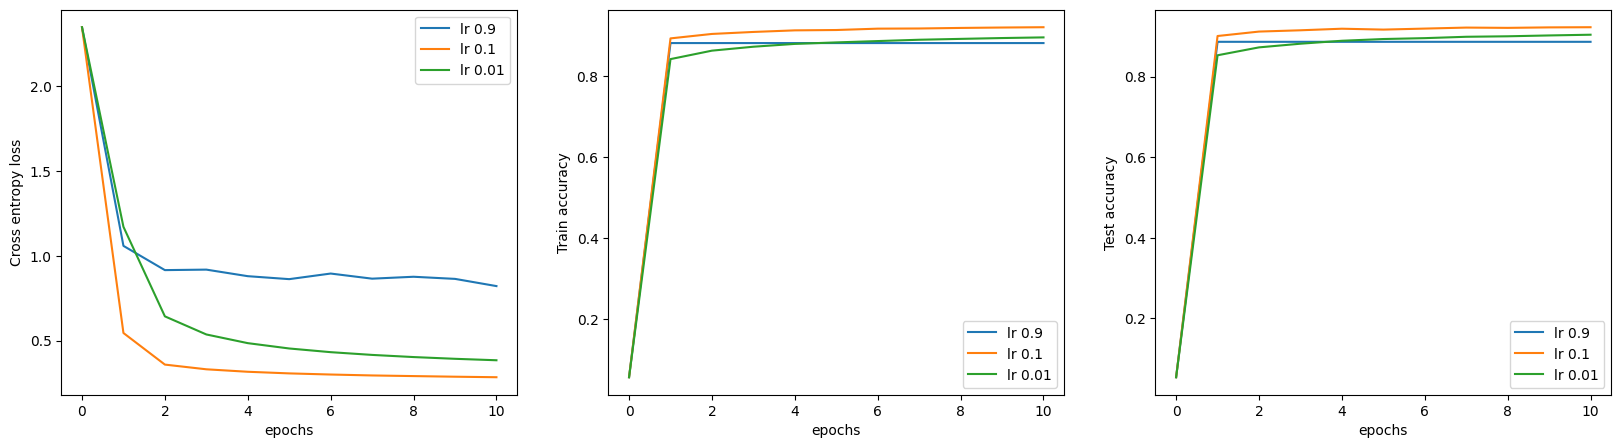

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(sgd_lr09_loss)), sgd_lr09_loss,label = 'lr 0.9', color = 'C0')
ax11.plot(range(len(sgd_lr01_loss)), sgd_lr01_loss,label = 'lr 0.1', color = 'C1')
ax11.plot(range(len(sgd_lr0001_loss)), sgd_lr0001_loss,label = 'lr 0.01', color = 'C2')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(sgd_lr09_train_acc)), sgd_lr09_train_acc,label = 'lr 0.9', color = 'C0')
ax21.plot(range(len(sgd_lr01_train_acc)), sgd_lr01_train_acc,label = 'lr 0.1', color = 'C1')
ax21.plot(range(len(sgd_lr0001_train_acc)), sgd_lr0001_train_acc,label = 'lr 0.01', color = 'C2')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(sgd_lr09_test_acc)), sgd_lr09_test_acc,label = 'lr 0.9', color = 'C0')
ax31.plot(range(len(sgd_lr01_test_acc)), sgd_lr01_test_acc,label = 'lr 0.1', color = 'C1')
ax31.plot(range(len(sgd_lr0001_test_acc)), sgd_lr0001_test_acc,label = 'lr 0.01', color = 'C2')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

#### 2.1.4 Learning rate scheduling: warm up vs decaying.

One good technique to improve convergence of your model is learning rate scheduling. The idea is to modify the value of the learning rate during the optimization, in an aim to achieve better convergence speeds.

There are two ways to modify learning rate. In modern machine learning techniques such as those deep architectures used for language modelling, a usual way to optimize the model is to start with a low learning rate, and increase the learning rate gradually up to some point. Then, optimization follows from that big learning rate and after some epochs you start decaying the learning rate.

Pytorch offers an interface for different ways of varying the learning rate, which is known with the name of learning rate schedulers.

##### Task: Learning rate scheduler

Implement a learning rate scheduler that, after 10 epochs, decays the learning rate by an order of magnitude of 1. To do so, simply modify your function to receive a boolean that, when true, applies learning rate scheduling and when false, does not. This scheduler is implemented in pytorch in `torch.optim.lr_scheduler` module.

To visualize the effect of learning rate scheduling, we are going to train using the test set and evaluate using the train set. This does not mean that this is going to be a general rule, however I have found this configuration usefull to showcase the effect of learning rate scheduling.

##### Task:

Train a five hidden layer neural network with relu activation, without learning rate scheduler, for 15 epochs, without applying scheduler. Use eval_each = 1. Use learning rate of 0.1, momentum of 0.9 and batch_size of 100.

Observe what happens from epoch 10.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 5
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

nosch_loss, nosch_train_acc, nosch_test_acc = test_model(
    model,
    epochs = 20,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = test_dataset,
    test_dataset = train_dataset
)

On epoch 1 got loss 2.22456 with train accuracy 0.42930 and test accuracy 0.42118                                                                                                                       
On epoch 2 got loss 0.82360 with train accuracy 0.87260 and test accuracy 0.85188                                                                                                                       
On epoch 3 got loss 0.36000 with train accuracy 0.93760 and test accuracy 0.91552                                                                                                                       
On epoch 4 got loss 0.20997 with train accuracy 0.95440 and test accuracy 0.92062                                                                                                                       
On epoch 5 got loss 0.18432 with train accuracy 0.95870 and test accuracy 0.92930                                                                                                                   

##### Task

Train a five hidden layer neural network with learning rate scheduler, for 20 epochs. Observe what happens from epoch 10, that is when the learning rate scheduler applies its decay.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 5
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


yessch_loss, yessch_train_acc, yessch_test_acc = test_model(
    model,
    epochs = 20,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = True,
    eval_each = 1,
    train_dataset = test_dataset,
    test_dataset = train_dataset
)


On epoch 1 got loss 2.22456 with train accuracy 0.42930 and test accuracy 0.42118                                                                                                                       
On epoch 2 got loss 0.82360 with train accuracy 0.87260 and test accuracy 0.85188                                                                                                                       
On epoch 3 got loss 0.36000 with train accuracy 0.93760 and test accuracy 0.91552                                                                                                                       
On epoch 4 got loss 0.20997 with train accuracy 0.95440 and test accuracy 0.92062                                                                                                                       
On epoch 5 got loss 0.18432 with train accuracy 0.95870 and test accuracy 0.92930                                                                                                                   

##### Task

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure comparing the the model trained with and without scheduler.

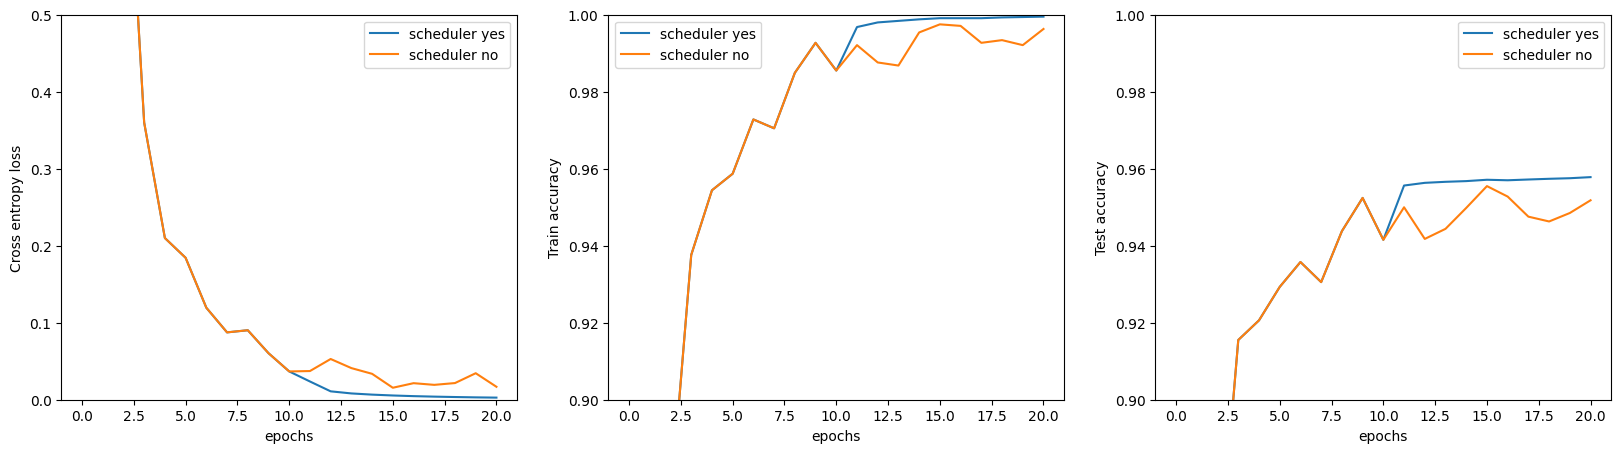

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(yessch_loss)), yessch_loss,label = 'scheduler yes', color = 'C0')
ax11.plot(range(len(nosch_loss)), nosch_loss,label = 'scheduler no', color = 'C1')
ax11.set_ylim([0,0.5])
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(yessch_train_acc)), yessch_train_acc,label = 'scheduler yes', color = 'C0')
ax21.plot(range(len(nosch_train_acc)), nosch_train_acc,label = 'scheduler no', color = 'C1')
ax21.set_ylim([0.9,1.0])
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(yessch_test_acc)), yessch_test_acc,label = 'scheduler yes', color = 'C0')
ax31.plot(range(len(nosch_test_acc)), nosch_test_acc,label = 'scheduler no', color = 'C1')
ax31.set_ylim([0.9,1.0])
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### 2.2 The effect of saturating non-linearities: gradient vanishing, sparsity, model initialization and the output range of an activation function.

In this part we will observe the differences in training the same neural network using sigmoid vs ReLU non-linearity.

You should observe how sigmoid network takes longer to reach the same accuracy as the relu network. The problem with the sigmoid is two fold:

* on initialization you can be in the saturating region. Moving out from it takes longer since gradients are small.
* even if at time step $t$ your model is not in the saturating part of the sigmoid, gradient updates at different layers can move some of the neurons at $t+1$ to its saturating region. This slows down learning since the gradients are small again for some parts, and network might need to readapt other neurons to explain the output.

From now on use momenutm $0.9$, batch size  $100$, learning rate $0.1$ with no scheduler unless opposite is mentioned. Revert back to use the train set as the train set and the test set as the test set.


###### TODO (juan):
* look for different ways of initializing the model to show case the problem.
* use wider tanh.

#### 2.2.1 Saturating non-linearities

##### Task

Train a four hidden neural network, with 32 neurons, and sigmoid activation for 10 epochs. Evalute each 1 epoch.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
neu_h = 32
num_h = 4
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h]*num_h,
              hidden_activations = [torch.sigmoid]*num_h,
              dropout_hidden = [0.0]*num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sigm_loss, sigm_train_acc, sigm_test_acc = test_model(
    model,
    epochs = 10,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 2.31038 with train accuracy 0.10442 and test accuracy 0.10280                                                                                                                       
On epoch 2 got loss 2.30462 with train accuracy 0.10442 and test accuracy 0.10280                                                                                                                       
On epoch 3 got loss 2.30380 with train accuracy 0.10442 and test accuracy 0.10280                                                                                                                       
On epoch 4 got loss 2.30203 with train accuracy 0.11237 and test accuracy 0.11350                                                                                                                       
On epoch 5 got loss 1.92315 with train accuracy 0.42878 and test accuracy 0.43910                                                                                                                   

##### Task

Train a four hidden neural network, with 32 neurons, and tanh activation for 10 epochs

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
neu_h = 32
num_h = 4
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h]*num_h,
              hidden_activations = [torch.tanh]*num_h,
              dropout_hidden = [0.0]*num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

tanh_loss, tanh_train_acc, tanh_test_acc = test_model(
    model,
    epochs = 10,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.42470 with train accuracy 0.93648 and test accuracy 0.93500                                                                                                                       
On epoch 2 got loss 0.19822 with train accuracy 0.95572 and test accuracy 0.94680                                                                                                                       
On epoch 3 got loss 0.16502 with train accuracy 0.95980 and test accuracy 0.95310                                                                                                                       
On epoch 4 got loss 0.14759 with train accuracy 0.96512 and test accuracy 0.95370                                                                                                                       
On epoch 5 got loss 0.13232 with train accuracy 0.96822 and test accuracy 0.95580                                                                                                                   

##### Task

Train a four hidden neural network, with 32 neurons, and relu activation for 10 epochs

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
neu_h = 32
num_h = 4
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h]*num_h,
              hidden_activations = [torch.relu]*num_h,
              dropout_hidden = [0.0]*num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

relu_loss, relu_train_acc, relu_test_acc = test_model(
    model,
    epochs = 10,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.60357 with train accuracy 0.93283 and test accuracy 0.93020                                                                                                                       
On epoch 2 got loss 0.22835 with train accuracy 0.94598 and test accuracy 0.94190                                                                                                                       
On epoch 3 got loss 0.19028 with train accuracy 0.94662 and test accuracy 0.94310                                                                                                                       
On epoch 4 got loss 0.17314 with train accuracy 0.96167 and test accuracy 0.95460                                                                                                                       
On epoch 5 got loss 0.15093 with train accuracy 0.96102 and test accuracy 0.95430                                                                                                                   

##### Task

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure comparing the different activation functions.

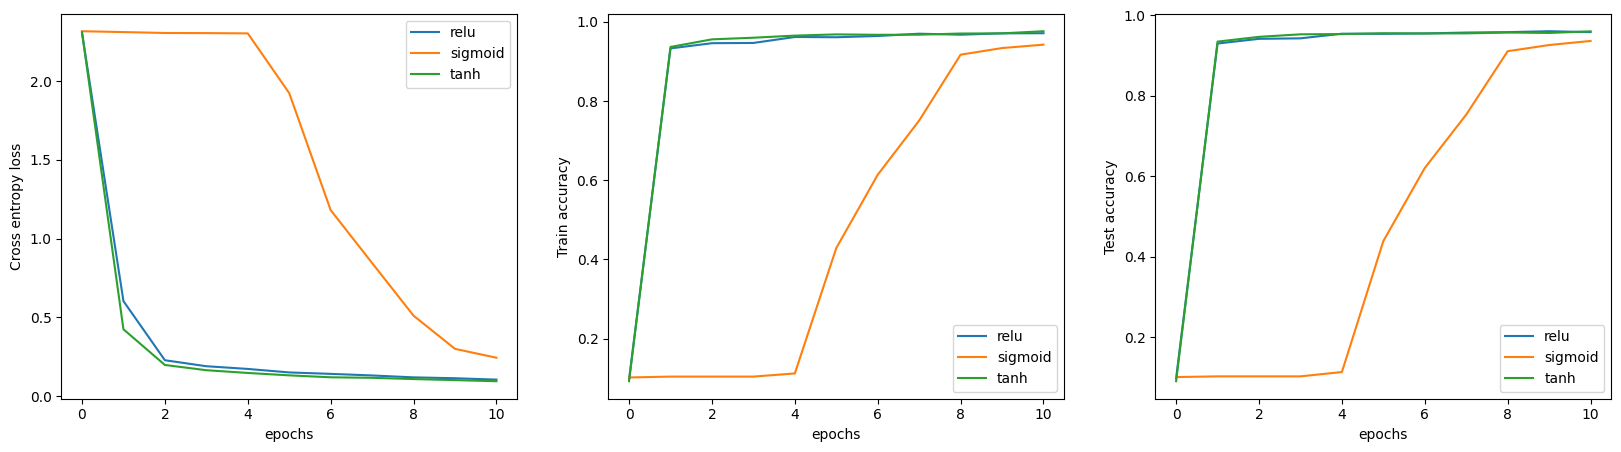

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(relu_loss)), relu_loss,label = 'relu', color = 'C0')
ax11.plot(range(len(sigm_loss)), sigm_loss,label = 'sigmoid', color = 'C1')
ax11.plot(range(len(tanh_loss)), tanh_loss,label = 'tanh', color = 'C2')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(relu_train_acc)), relu_train_acc,label = 'relu', color = 'C0')
ax21.plot(range(len(sigm_train_acc)), sigm_train_acc,label = 'sigmoid', color = 'C1')
ax21.plot(range(len(tanh_train_acc)), tanh_train_acc,label = 'tanh', color = 'C2')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(relu_test_acc)), relu_test_acc,label = 'relu', color = 'C0')
ax31.plot(range(len(sigm_test_acc)), sigm_test_acc,label = 'sigmoid', color = 'C1')
ax31.plot(range(len(tanh_test_acc)), tanh_test_acc,label = 'tanh', color = 'C2')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### 2.3 Overfitting in neural networks.

As you know from machine learning lectures, complex models tend to overfit by learning the training data without generalizing to test data.

Let's try and observe this effects by training a 1 hidden and 5 hidden layers neural networks. As you will see you do not observe the typical effect of the test metric curve going down and up, while training metric goes down.

##### Task:

Train a one hidden layer with 1024 neurons during 30 epochs. Evaluate each 1 epoch.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 1
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


one_1024_loss, one_1024_train_acc, one_1024_test_acc = test_model(
    model,
    epochs = 30,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.23528 with train accuracy 0.96927 and test accuracy 0.96390                                                                                                                       
On epoch 2 got loss 0.08618 with train accuracy 0.98453 and test accuracy 0.97720                                                                                                                       
On epoch 3 got loss 0.05641 with train accuracy 0.99083 and test accuracy 0.98110                                                                                                                       
On epoch 4 got loss 0.03899 with train accuracy 0.99380 and test accuracy 0.98260                                                                                                                       
On epoch 5 got loss 0.02682 with train accuracy 0.99507 and test accuracy 0.98290                                                                                                                   

##### Task:

Train a one hidden layer with 4096 neurons during 30 epochs.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 1
neu_h = 4096
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


one_4096_loss, one_4096_train_acc, one_4096_test_acc = test_model(
    model,
    epochs = 30,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
)

On epoch 1 got loss 0.21631 with train accuracy 0.97592 and test accuracy 0.97150                                                                                                                       
On epoch 2 got loss 0.07567 with train accuracy 0.98203 and test accuracy 0.97420                                                                                                                       
On epoch 3 got loss 0.04724 with train accuracy 0.99050 and test accuracy 0.97870                                                                                                                       
On epoch 4 got loss 0.03073 with train accuracy 0.99225 and test accuracy 0.97730                                                                                                                       
On epoch 5 got loss 0.02076 with train accuracy 0.99620 and test accuracy 0.98110                                                                                                                   

##### Task:

Train a five hidden layer with 1024 neurons during 30 epochs.

In [ ]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 5
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


five_loss, five_train_acc, five_test_acc = test_model(
    model,
    epochs = 30,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
)

On epoch 1 got loss 0.61030 with train accuracy 0.95025 and test accuracy 0.94370                                                                                                                       
On epoch 2 got loss 0.13787 with train accuracy 0.97003 and test accuracy 0.96190                                                                                                                       
On epoch 3 got loss 0.09397 with train accuracy 0.98098 and test accuracy 0.96940                                                                                                                       
On epoch 4 got loss 0.07307 with train accuracy 0.98693 and test accuracy 0.97680                                                                                                                       
On epoch 5 got loss 0.05376 with train accuracy 0.98990 and test accuracy 0.97840                                                                                                                   

##### Task

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure of the one vs five hidden layer models.

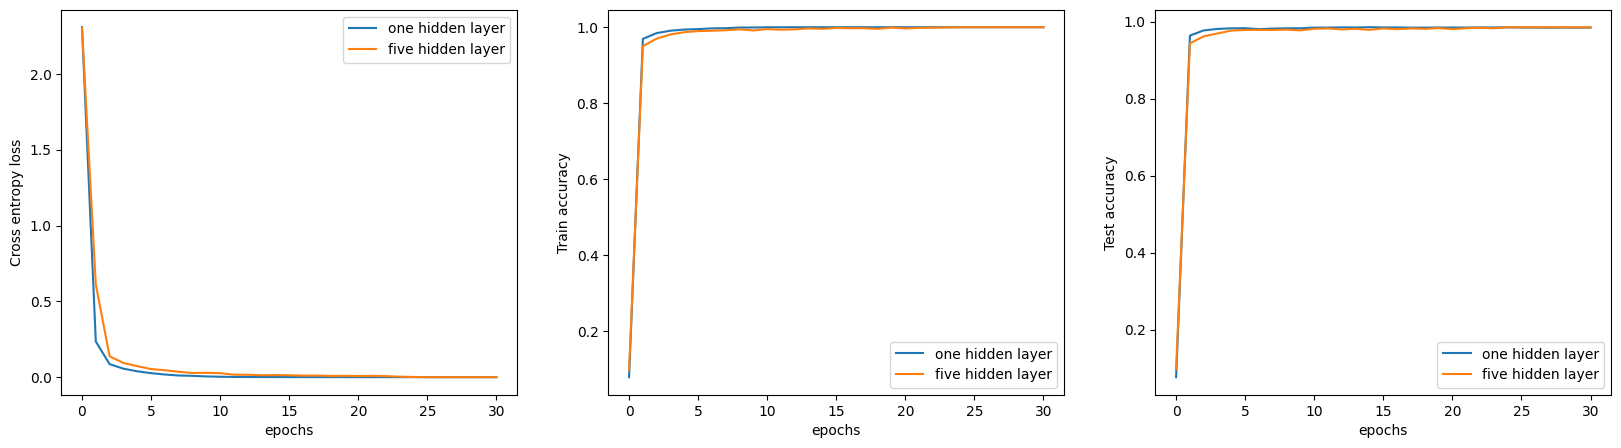

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(one_1024_loss)), one_1024_loss,label = 'one hidden layer', color = 'C0')
ax11.plot(range(len(five_loss)), five_loss,label = 'five hidden layer', color = 'C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(one_1024_train_acc)), one_1024_train_acc,label = 'one hidden layer', color = 'C0')
ax21.plot(range(len(five_train_acc)), five_train_acc,label = 'five hidden layer', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(one_1024_test_acc)), one_1024_test_acc,label = 'one hidden layer', color = 'C0')
ax31.plot(range(len(five_test_acc)), five_test_acc,label = 'five hidden layer', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

#### 2.3.1 Dropout

Dropout is a regularization technique which works by setting neurons activation sto $0$ with some probability. This improves the performance of your model.

As you saw previously, eventhough Neural Networks do not show the typical overfitting pathologies, this does not mean they are actually overfitting. As you saw previously the training error and optimization loss went to zero, which means the network learnt to predict each of the training samples with probability $1$ to its correct label.

It is curious to see, anyway, that increasing expresivness did actually obtained a better loss error on the training, but that did not imply starting to classify worse on the test set. The reason under this could be that the there is not too much noise in the data, in the sense that distribution shift between training and test sets is not so high, compared to the amount of training data, that we can learn enough generalizing patterns that extrapolate well to most of the test set.

Let's try an mimic this behaviour by training on a smaller amount of data. Since mnist has $10000$ test samples and $60000$ training samples, we can just switch and train with the test data, and test with the training data.

##### Task

Train a one hidden layer with 1024 neurons during 30 epochs, using the test dataset as train dataset. Eval each 1 epoch.

In [7]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 1
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


one_loss, one_train_acc, one_test_acc = test_model(
    model,
    epochs = 30,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = test_dataset,
    test_dataset = train_dataset
)

On epoch 1 got loss 0.57301 with train accuracy 0.93490 and test accuracy 0.91213
On epoch 2 got loss 0.19148 with train accuracy 0.96430 and test accuracy 0.93195
On epoch 3 got loss 0.10941 with train accuracy 0.97440 and test accuracy 0.93850
On epoch 4 got loss 0.07171 with train accuracy 0.98980 and test accuracy 0.94802
On epoch 5 got loss 0.04330 with train accuracy 0.99450 and test accuracy 0.95075
On epoch 6 got loss 0.03209 with train accuracy 0.99360 and test accuracy 0.94952
On epoch 7 got loss 0.02116 with train accuracy 0.99920 and test accuracy 0.95437
On epoch 8 got loss 0.01220 with train accuracy 1.00000 and test accuracy 0.95627
On epoch 9 got loss 0.00855 with train accuracy 0.99980 and test accuracy 0.95548
On epoch 10 got loss 0.00684 with train accuracy 0.99990 and test accuracy 0.95680
On epoch 11 got loss 0.00522 with train accuracy 1.00000 and test accuracy 0.95700
On epoch 12 got loss 0.00437 with train accuracy 1.00000 and test accuracy 0.95725
On epoch 13 g

##### Task

Train a three hidden layer with 1024 neurons during 30 epochs. In this one, apply learning rate scheduling.

In [8]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 3
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


three_loss, three_train_acc, three_test_acc = test_model(
    model,
    epochs = 30,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = True,
    eval_each =  1,
    train_dataset = test_dataset,
    test_dataset = train_dataset
)

On epoch 1 got loss 0.93381 with train accuracy 0.92820 and test accuracy 0.90740
On epoch 2 got loss 0.22615 with train accuracy 0.94820 and test accuracy 0.92103
On epoch 3 got loss 0.13600 with train accuracy 0.97770 and test accuracy 0.94362
On epoch 4 got loss 0.08758 with train accuracy 0.97490 and test accuracy 0.93810
On epoch 5 got loss 0.05860 with train accuracy 0.98120 and test accuracy 0.94502
On epoch 6 got loss 0.04604 with train accuracy 0.99090 and test accuracy 0.94947
On epoch 7 got loss 0.04886 with train accuracy 0.98620 and test accuracy 0.94568
On epoch 8 got loss 0.03571 with train accuracy 0.99220 and test accuracy 0.94698
On epoch 9 got loss 0.02633 with train accuracy 0.99720 and test accuracy 0.95612
On epoch 10 got loss 0.00841 with train accuracy 0.99890 and test accuracy 0.95912
On epoch 11 got loss 0.00420 with train accuracy 0.99830 and test accuracy 0.96013
On epoch 12 got loss 0.01236 with train accuracy 0.99950 and test accuracy 0.95945
On epoch 13 g

##### Task

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure of the one vs three hidden layer models.

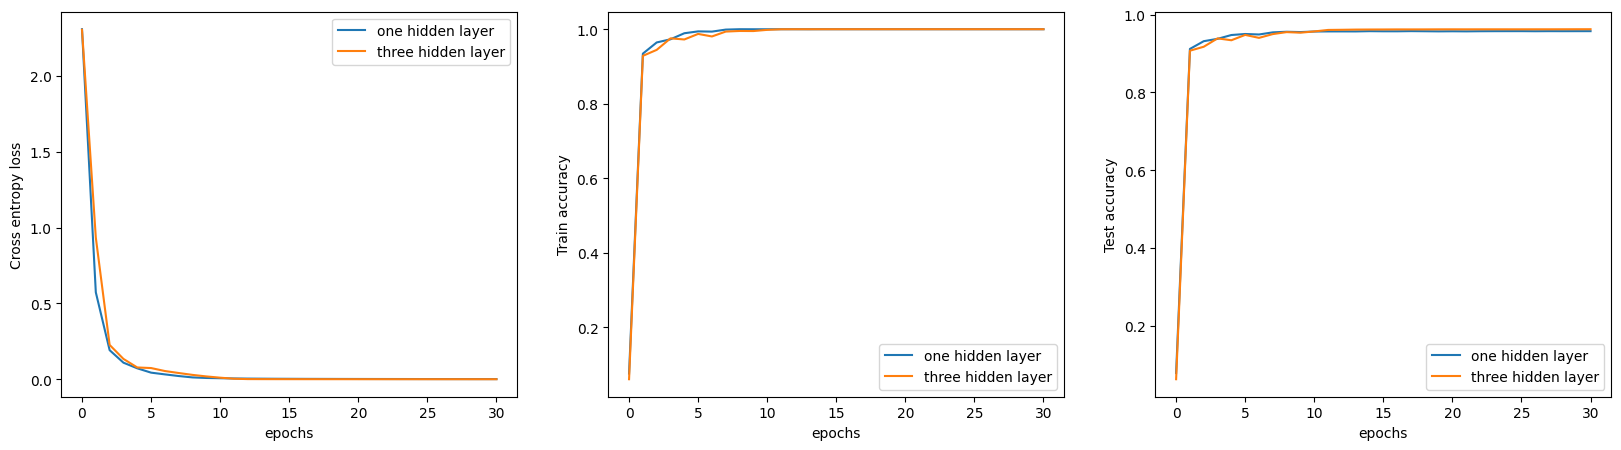

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(one_loss)), one_loss,label = 'one hidden layer', color = 'C0')
ax11.plot(range(len(three_loss)), three_loss,label = 'three hidden layer', color = 'C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(one_train_acc)), one_train_acc,label = 'one hidden layer', color = 'C0')
ax21.plot(range(len(three_train_acc)), three_train_acc,label = 'three hidden layer', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(one_test_acc)), one_test_acc,label = 'one hidden layer', color = 'C0')
ax31.plot(range(len(three_test_acc)), three_test_acc,label = 'three hidden layer', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

We still do not observe this effect of overfitting.

However, let's see the effect of dropout in these models.

##### Task:

Since dropout works differently during training and test, modify your Fully connected neural network implementation to have a forward train and a forward evaluation methods. To change the behaviour of neural network's layers, `torch.nn` module provides the `train` and `eval` methods. So basically from your models you can call `self.train()` or `self.eval()`, and pytorch will modify the behaviour of all the layers that have different operating modes.

Note that, you should modify also your metric and train functions to call these different methods. So instead of having

```python
class FCDNN(nn.Module):
        
    def forward(self,x, apply_link):
        ...
```

you should now have:

```python
class FCDNN(nn.Module):
        
    def forward_train(self,x, apply_link):
        ...
        
    def forward_eval(self,x, apply_link):
        ...
```

##### Task: Implement dropout

Implement dropout in your model. You can use the layer `nn.Dropout` from the `nn.Module`. To do so, you need to modify your created class in the following ways.

* The `FCDNN` class must receive a list with the dropout probability to apply to each hidden layer.
* The output layer should have a dropout of 0.0.
* The class FCLayer should receive an argument drop that provides the dropout probability to apply.

In [ ]:
if assesment_draw_and_fill:
    code = """```python

def linear_link(x):
    return x

class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act, drop):
        super().__init__()
        ## create parameters
        self.linear = ...
        self.act = ...
        self.drop = ...

    def forward(self, x):
        fx = ...
        return fx

class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, dropout_hidden link_function, loss_function):
        super().__init__()

        assert len(neurons_hidden) == len(hidden_activations), "List specifying hidden activations and number of hidden layers must coincide"
        assert len(neurons_hidden) == len(dropout_hidden), "List specifying hidden activations and dropout per layer"


        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):
            module_list.append(...)
            dim_in = num_neur

        # output layer
        o_layer = FCLayer(...)
        module_list.append(o_layer)

        self.layers = module_list

        ## Loss and link function
        self.link = ...
        self.loss = ...

    def forward_train(self,x, apply_link):
        ...

    def forward_eval(self,x, apply_link):
        ...

    def compute_loss(self,t,y):
        ...
```"""

##### Task:

Train a one hidden layer neural network with 1024 neurons using 0.5 dropout probability, during 30 epochs. Do not apply scheduling.

In [9]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 1
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.5] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


one_drop05_loss, one_drop05_train_acc, one_drop05_test_acc = test_model(
    model,
    epochs = 30,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = test_dataset,
    test_dataset = train_dataset
)

On epoch 1 got loss 0.62977 with train accuracy 0.92000 and test accuracy 0.89597
On epoch 2 got loss 0.26012 with train accuracy 0.95580 and test accuracy 0.93020
On epoch 3 got loss 0.18172 with train accuracy 0.96970 and test accuracy 0.93892
On epoch 4 got loss 0.14646 with train accuracy 0.97830 and test accuracy 0.94642
On epoch 5 got loss 0.11109 with train accuracy 0.98270 and test accuracy 0.94833
On epoch 6 got loss 0.09274 with train accuracy 0.98800 and test accuracy 0.95190
On epoch 7 got loss 0.08065 with train accuracy 0.98610 and test accuracy 0.95030
On epoch 8 got loss 0.05737 with train accuracy 0.98880 and test accuracy 0.94860
On epoch 9 got loss 0.05442 with train accuracy 0.99450 and test accuracy 0.95513
On epoch 10 got loss 0.05300 with train accuracy 0.99540 and test accuracy 0.95408
On epoch 11 got loss 0.03802 with train accuracy 0.99820 and test accuracy 0.95818
On epoch 12 got loss 0.03378 with train accuracy 0.99790 and test accuracy 0.95805
On epoch 13 g

##### Task:

Train a three hidden layer neural network with 1024 neurons using 0.5 dropout probability, during 30 epochs. Apply scheduling.

In [11]:
torch.manual_seed(0)
device = 'cpu'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 3
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.5] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


three_drop05_loss, three_drop05_train_acc, three_drop05_test_acc = test_model(
        model,
        epochs = 30,
        lr = 0.1,
        mmu = 0.9,
        train_batch_size = 100,
        apply_scheduler = True,
        eval_each = 1,
        train_dataset = test_dataset,
        test_dataset = train_dataset
)

On epoch 1 got loss 1.10784 with train accuracy 0.90790 and test accuracy 0.88482
On epoch 2 got loss 0.43359 with train accuracy 0.92590 and test accuracy 0.90950
On epoch 3 got loss 0.33309 with train accuracy 0.95460 and test accuracy 0.93112
On epoch 4 got loss 0.29508 with train accuracy 0.95120 and test accuracy 0.92653
On epoch 5 got loss 0.26334 with train accuracy 0.96510 and test accuracy 0.93657
On epoch 6 got loss 0.23464 with train accuracy 0.97210 and test accuracy 0.94478
On epoch 7 got loss 0.20227 with train accuracy 0.97030 and test accuracy 0.94008
On epoch 8 got loss 0.20020 with train accuracy 0.97080 and test accuracy 0.94023
On epoch 9 got loss 0.17533 with train accuracy 0.98200 and test accuracy 0.95033
On epoch 10 got loss 0.16486 with train accuracy 0.98090 and test accuracy 0.94788
On epoch 11 got loss 0.14172 with train accuracy 0.98280 and test accuracy 0.95038
On epoch 12 got loss 0.14923 with train accuracy 0.98670 and test accuracy 0.95272
On epoch 13 g

##### Task

Draw three figures where you plot the loss, training accuracy and test accuracy of the training proceedure of the one vs three hidden layer models using dropout and no dropout.

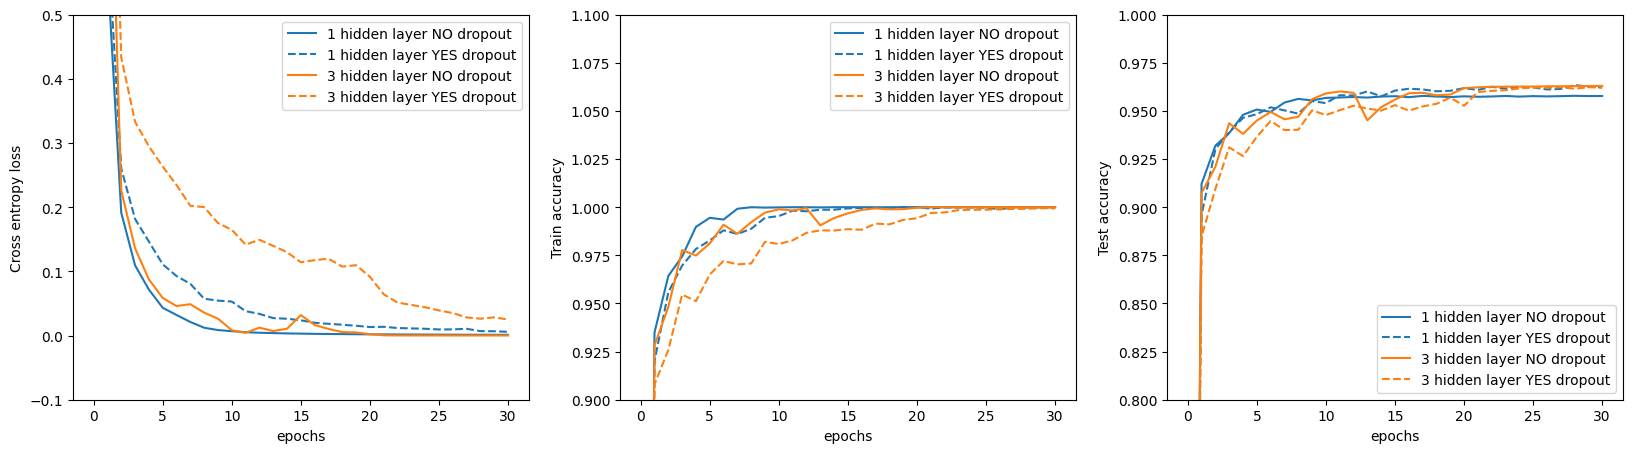

In [12]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))


## Plot cross entropy loss
ax11.plot(range(len(one_loss)), one_loss,label = '1 hidden layer NO dropout', color = 'C0')
ax11.plot(range(len(one_drop05_loss)), one_drop05_loss, label = '1 hidden layer YES dropout', color = 'C0', linestyle = '--' )
ax11.plot(range(len(three_loss)), three_loss,label = '3 hidden layer NO dropout', color = 'C1')
ax11.plot(range(len(three_drop05_loss)), three_drop05_loss, label = '3 hidden layer YES dropout', color = 'C1', linestyle = '--' )
ax11.set_ylim([-0.1, 0.5])
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(one_train_acc)), one_train_acc,label = '1 hidden layer NO dropout', color = 'C0')
ax21.plot(range(len(one_drop05_train_acc)), one_drop05_train_acc, label = '1 hidden layer YES dropout', color = 'C0', linestyle = '--' )
ax21.plot(range(len(three_train_acc)), three_train_acc,label = '3 hidden layer NO dropout', color = 'C1')
ax21.plot(range(len(three_drop05_train_acc)), three_drop05_train_acc, label = '3 hidden layer YES dropout', color = 'C1', linestyle = '--' )
ax21.set_ylim([0.9, 1.1])
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(one_test_acc)), one_test_acc,label = '1 hidden layer NO dropout', color = 'C0')
ax31.plot(range(len(one_drop05_test_acc)), one_drop05_test_acc, label = '1 hidden layer YES dropout', color = 'C0', linestyle = '--' )
ax31.plot(range(len(three_test_acc)), three_test_acc,label = '3 hidden layer NO dropout', color = 'C1')
ax31.plot(range(len(three_drop05_test_acc)), three_drop05_test_acc, label = '3 hidden layer YES dropout', color = 'C1', linestyle = '--' )
ax31.set_ylim([0.8, 1.0])
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

##### Task:

As you can see the deeper network with dropout does not surpass the one without dropout. Note that deeper networks can take longer to train, and also dropout networks can as well. If you have time, train the three layer's dropout network for 100 epochs and see what happens. Apply scheduling of 20-60 in the MultiStep LR scheduler.

In [12]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 3
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.5] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


three_drop05_loss, three_drop05_train_acc, three_drop05_test_acc = test_model(
        model,
        epochs = 100,
        lr = 0.1,
        mmu = 0.9,
        train_batch_size = 100,
        apply_scheduler = True,
        eval_each = 10,
        train_dataset = test_dataset,
        test_dataset = train_dataset
)

On epoch 1 got loss 1.09584 with train accuracy 0.90540 and test accuracy 0.88930
On epoch 2 got loss 0.39007
On epoch 3 got loss 0.32648
On epoch 4 got loss 0.30415
On epoch 5 got loss 0.23971
On epoch 6 got loss 0.22932
On epoch 7 got loss 0.21279
On epoch 8 got loss 0.19171
On epoch 9 got loss 0.16975
On epoch 10 got loss 0.16147 with train accuracy 0.97710 and test accuracy 0.94520
On epoch 11 got loss 0.16357
On epoch 12 got loss 0.14065
On epoch 13 got loss 0.13276
On epoch 14 got loss 0.13072
On epoch 15 got loss 0.14192
On epoch 16 got loss 0.11894
On epoch 17 got loss 0.11078
On epoch 18 got loss 0.10509
On epoch 19 got loss 0.10872
On epoch 20 got loss 0.08443 with train accuracy 0.99370 and test accuracy 0.95602
On epoch 21 got loss 0.06571
On epoch 22 got loss 0.04878
On epoch 23 got loss 0.03888
On epoch 24 got loss 0.03604
On epoch 25 got loss 0.03589
On epoch 26 got loss 0.02974
On epoch 27 got loss 0.02875
On epoch 28 got loss 0.03234
On epoch 29 got loss 0.02704
On epo

## 2.4: Residual Connections.

Residual connections are one of the breakthroughs in deep learning over the years. Is the most cited contribution in the community. The idea behind residual connections is the following:

Consider a set of neural network layers (for example a couple of linear proyections followed by activations, one after one). A residual connection readds the input to a layer to its output. More precisely:

$$
H = X + \phi( \text{Linear}(X,W) )
$$

where Linear denotes a set of linear operations (matrix product, convolution and batch normalization) and $\phi$ is the usual element-wise activation function. We could, additionally, consider dropout here. In other words, the idea is to readd the input to the output of a set of operations.

With this, we note that the gradient of $H$ wrt $X$ would be something like:

$$
\frac{\partial H }{\partial X} = 1 + \frac{\partial \phi( \text{Linear}(X,W) )}{\partial X}
$$

which will, as you can see, remove any gradient vanishing problem.

While this could look like a nice justification for deep residual learning, it is not actually the motivation. The motivation is a bit far more complicated from the intuitive point and is regarded to the fact that training very deep networks without residual connections do not achieve a good generalization error although the magnitude of the gradient does not vanish to zero.

However, for small networks or saturating non-linearities it is obviously something that we can mathematically demonstrate. Gradient does not vanishd due to saturating non linearities or due to the zero setting problem of the relu. Obviously, as we can think a good initialization of model parameters can also remove this problem, but residual networks, by construction, make the model less sensitive to initialization, as batch normalization does (see next).  

##### Task

Modify your neural network class so that through a boolean (named apply_residual), applies residual to each of the hidden layers. Note that if you need to add a residual layer after a change of dimensionality (for example if you pass from a hidden layer of 100 neurons, to a hidden layer of 200 neurons), you need to readapt the input through a linear operator before adding. We call this the bottleneck.

In [14]:
if assesment_draw_and_fill:
  code = """```python
def linear_link(x):
    return x

class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act, drop, add_residual):
        super().__init__()
        ## create parameters
        self.linear = ...
        self.act = ...
        self.drop = ...

        self.add_residual = ...
        # when residual is needed we need to readapt input
        if add_residual and dim_in != dim_out:
            self.bottleneck = ...
        else:
            self.bottleneck = linear_link

    def forward(self, x):
        fx = ...
        if self.add_residual:
            fx = ...
        return fx


class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, dropout_hidden, add_residual:bool, link_function, loss_function):
        super().__init__()

        assert len(neurons_hidden) == len(hidden_activations), "List specifying hidden activations and number of hidden layers must coincide"
        assert len(neurons_hidden) == len(dropout_hidden), "List specifying hidden activations and dropout per layer"


        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):
            module_list.append(...)
            dim_in = num_neur

        # output layer
        o_layer = FCLayer(...)
        module_list.append(o_layer)

        self.layers = module_list

        ## Loss and link function
        self.link = ...
        self.loss = ...

    def forward_train(self,x, apply_link):
        ...

    def forward_eval(self,x, apply_link):
        ...

    def compute_loss(self,t,y):
        ...
```
  """
  display(Markdown(code))

```python
def linear_link(x):
    return x
    
class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act, drop, add_residual):
        super().__init__()
        ## create parameters
        self.linear = ...
        self.act = ...
        self.drop = ...

        self.add_residual = ...
        # when residual is needed we need to readapt input
        if add_residual and dim_in != dim_out:
            self.bottleneck = ...
        else:
            self.bottleneck = linear_link
        
    def forward(self, x):
        fx = ...
        if self.add_residual:
            fx = ...
        return fx


class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, dropout_hidden, add_residual:bool, link_function, loss_function):
        super().__init__()

        assert len(neurons_hidden) == len(hidden_activations), "List specifying hidden activations and number of hidden layers must coincide"
        assert len(neurons_hidden) == len(dropout_hidden), "List specifying hidden activations and dropout per layer"

        
        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):
            module_list.append(...)
            dim_in = num_neur

        # output layer
        o_layer = FCLayer(...)
        module_list.append(o_layer)

        self.layers = module_list
       
        ## Loss and link function
        self.link = ...
        self.loss = ...
        
    def forward_train(self,x, apply_link):
        ...
    
    def forward_eval(self,x, apply_link):
        ...

    def compute_loss(self,t,y):
        ...
```
  

##### Task

Train a neural network with 10 hidden layers, with ten neurons per layer, and relu activation, without residual connections, for 30 epochs. Use eval_each 10 epochs. Revert back and start using the standard training and test set as always.

In [15]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
n_h = 10
neu_h = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [10]*n_h,
              hidden_activations = [torch.relu]*n_h,
              dropout_hidden = [0.0]*n_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

ten_no_res_loss, ten_no_res_train_acc, ten_no_res_test_acc = test_model(
        model,
        epochs = 30,
        lr = 0.1,
        mmu = 0.9,
        train_batch_size = 100,
        apply_scheduler = False,
        eval_each = 10,
        train_dataset = train_dataset,
        test_dataset = test_dataset
)

On epoch 1 got loss 2.30388 with train accuracy 0.09863 and test accuracy 0.09580
On epoch 2 got loss 2.30389
On epoch 3 got loss 2.30360
On epoch 4 got loss 2.30382
On epoch 5 got loss 2.30337
On epoch 6 got loss 2.30334
On epoch 7 got loss 2.30331
On epoch 8 got loss 2.30366
On epoch 9 got loss 2.30339
On epoch 10 got loss 2.30345 with train accuracy 0.10442 and test accuracy 0.10280
On epoch 11 got loss 2.30329
On epoch 12 got loss 2.30341
On epoch 13 got loss 2.30352
On epoch 14 got loss 2.30310
On epoch 15 got loss 2.30339
On epoch 16 got loss 2.30365
On epoch 17 got loss 2.30336
On epoch 18 got loss 2.30341
On epoch 19 got loss 2.30343
On epoch 20 got loss 2.30357 with train accuracy 0.10442 and test accuracy 0.10280
On epoch 21 got loss 2.30370
On epoch 22 got loss 2.30369
On epoch 23 got loss 2.30358
On epoch 24 got loss 2.30333
On epoch 25 got loss 2.30356
On epoch 26 got loss 2.30348
On epoch 27 got loss 2.30338
On epoch 28 got loss 2.30371
On epoch 29 got loss 2.30378
On epo

##### Task

Train a neural network with 10 hidden layers and relu activation, with residual connections, for 30 epochs, with lr = 0.01 and eval each 10 iterations.

In [16]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 10
neur = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur]*num_h,
              hidden_activations = [torch.relu]*num_h,
              dropout_hidden = [0.0]*num_h,
              batch_norm = False,
              add_residual = True,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

ten_yes_loss, ten_yes_train_acc, ten_yes_test_acc = test_model(
        model,
        epochs = 30,
        lr = 0.01,
        mmu = 0.9,
        train_batch_size = 100,
        apply_scheduler = True,
        eval_each = 10,
        train_dataset = train_dataset,
        test_dataset = test_dataset
)

On epoch 1 got loss 0.49446 with train accuracy 0.92460 and test accuracy 0.92450
On epoch 2 got loss 0.23229
On epoch 3 got loss 0.19360
On epoch 4 got loss 0.17187
On epoch 5 got loss 0.16153
On epoch 6 got loss 0.14997
On epoch 7 got loss 0.14423
On epoch 8 got loss 0.13742
On epoch 9 got loss 0.13288
On epoch 10 got loss 0.12915 with train accuracy 0.96235 and test accuracy 0.95230
On epoch 11 got loss 0.12598
On epoch 12 got loss 0.11961
On epoch 13 got loss 0.11876
On epoch 14 got loss 0.11453
On epoch 15 got loss 0.11486
On epoch 16 got loss 0.11157
On epoch 17 got loss 0.10875
On epoch 18 got loss 0.10435
On epoch 19 got loss 0.10408
On epoch 20 got loss 0.10286 with train accuracy 0.97045 and test accuracy 0.95820
On epoch 21 got loss 0.07618
On epoch 22 got loss 0.07173
On epoch 23 got loss 0.07016
On epoch 24 got loss 0.06895
On epoch 25 got loss 0.06805
On epoch 26 got loss 0.06735
On epoch 27 got loss 0.06670
On epoch 28 got loss 0.06614
On epoch 29 got loss 0.06577
On epo

### 2.5: Batch Normalization

Batch normalization (in general, normalization layers) is probably one of the biggest breakthroughs in deep learning, alongside with residual connections.

Since batch normalization centers the pre activations to have zero mean standar deviation, and due to the fact that the output of a linear projection is approximately a Gaussian distribution, the effect of batch normalization is to fix the distribution of pre activation to be approximately Gaussian.

According to the authors, this can fix many of the problems that have been fixed thanks to normalizing the data, such as, for example loss function preconditioning. They mention this removes what they call the internal covariate shift however from a practical, didactic, and introductory view point, these are the benefits we can expect from batch normalization, from its construction.

1. Makes initialization easier, since it centers preactivations to have zero mean, saturating activation functions will not be initialized in their saturating region, regardless of the initialization of the weights. Also, there is no need to careful initialization for weights used in ReLu networks, to avoid the whole Relu network to be on the negative side or positive side. Note that a ReLu on the negative side suffers from forward vanishing, while on the possitive part is equivalent to a linear model, which can take many epochs to converge to the non linear part.
2. Makes optimization easier. Since all dimensions are normalized, there is no single weight gradient that can be scaled by a bigger value, which can implies instabilities (ie exploiting gradients). This allows higher learning rate and decouples the value of the learning rate from the parameter, making optimization less dependent on adaptative learning rate methods.
3. Improves regularization, since injects noise in the network from computing mean and variance from a random minibatch.
4. Since it centers preactivations, they will have both possitive and negative values, which is desirable to have a expected value around zero for unbounded activations function such as ReLu.

###### Task

Implement batch normalization in your model network's hidden layer. You can use `nn.Batchnorm` from the `torch.nn` module. BatchNormalization should be applied over the hidden layers of the network.

In [20]:
if assesment_draw_and_fill:
  code = """```python
def linear_link(x):
    return x

class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act, drop, batch_norm, add_residual):
        super().__init__()
        ## create parameters
        self.linear = ...
        self.act = ...
        self.drop = ...
        if batch_norm:
            self.bn = ...
        else:
            self.bn = linear_link

        self.add_residual = add_residual
        # when residual is needed we need to readapt input
        if add_residual and dim_in != dim_out:
            self.bottleneck = ...
        else:
            self.bottleneck = linear_link


    def forward(self, x):
        fx = ...
        if self.add_residual:
            fx = ...
        return fx


class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, dropout_hidden, batch_norm: bool, add_residual:bool, link_function, loss_function):
        super().__init__()

        assert len(neurons_hidden) == len(hidden_activations), "List specifying hidden activations and number of hidden layers must coincide"
        assert len(neurons_hidden) == len(dropout_hidden), "List specifying hidden activations and dropout per layer"


        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):
            module_list.append(...)
            dim_in = num_neur

        # output layer
        o_layer = FCLayer(...)
        module_list.append(o_layer)

        self.layers = module_list

        ## Loss and link function
        self.link = ...
        self.loss = ...

    def forward_train(self,x, apply_link):
        ...

    def forward_eval(self,x, apply_link):
        ...

    def compute_loss(self,t,y):
        ...
```
  """
  display(Markdown(code))

```python
def linear_link(x):
    return x
    
class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act, drop, batch_norm, add_residual):
        super().__init__()
        ## create parameters
        self.linear = ...
        self.act = ...
        self.drop = ...
        if batch_norm:
            self.bn = ...
        else:
            self.bn = linear_link

        self.add_residual = add_residual
        # when residual is needed we need to readapt input
        if add_residual and dim_in != dim_out:
            self.bottleneck = ...
        else:
            self.bottleneck = linear_link
        
        
    def forward(self, x):
        fx = ...
        if self.add_residual:
            fx = ...
        return fx


class FCDNN(nn.Module):
    def __init__(self, dim_in, dim_out, neurons_hidden : list, hidden_activations:list, dropout_hidden, batch_norm: bool, add_residual:bool, link_function, loss_function):
        super().__init__()

        assert len(neurons_hidden) == len(hidden_activations), "List specifying hidden activations and number of hidden layers must coincide"
        assert len(neurons_hidden) == len(dropout_hidden), "List specifying hidden activations and dropout per layer"

        
        module_list = nn.ModuleList([])

        # input layer hidden layers
        for num_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):
            module_list.append(...)
            dim_in = num_neur

        # output layer
        o_layer = FCLayer(...)
        module_list.append(o_layer)

        self.layers = module_list
       
        ## Loss and link function
        self.link = ...
        self.loss = ...
        
    def forward_train(self,x, apply_link):
        ...
    
    def forward_eval(self,x, apply_link):
        ...

    def compute_loss(self,t,y):
        ...
```
  

#### 2.5.1: Saturating activation functions.

Making initializtion easier for saturating activation functions.

##### Task

Train a four hidden neural network, with 32 neurons, and sigmoid activation for 5 epochs, without batch normalization.

In [21]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 4
neur = 32
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur]*num_h,
              hidden_activations = [torch.sigmoid]*num_h,
              dropout_hidden = [0.0]*num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sigm_no_bn_loss, sigm_no_bn_train_acc, sigm_no_bn_test_acc = test_model(
    model,
    epochs = 5,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
)

On epoch 1 got loss 2.31038 with train accuracy 0.10442 and test accuracy 0.10280
On epoch 2 got loss 2.30462 with train accuracy 0.10442 and test accuracy 0.10280
On epoch 3 got loss 2.30380 with train accuracy 0.10442 and test accuracy 0.10280
On epoch 4 got loss 2.30203 with train accuracy 0.11237 and test accuracy 0.11350
On epoch 5 got loss 1.92315 with train accuracy 0.42878 and test accuracy 0.43910


##### Task

Train a four hidden neural network, with 32 neurons, and sigmoid activation for 10 epochs, with batch normalization.

In [23]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 4
neur = 32
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur]*num_h,
              hidden_activations = [torch.sigmoid]*num_h,
              dropout_hidden = [0.0]*num_h,
              batch_norm = True,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

sigm_yes_bn_loss, sigm_yes_bn_train_acc, sigm_yes_bn_test_acc = test_model(
    model,
    epochs = 5,
    lr = 0.1,
    mmu = 0.9,
    train_batch_size = 100,
    apply_scheduler = False,
    eval_each = 1,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
)

On epoch 1 got loss 0.42788 with train accuracy 0.92840 and test accuracy 0.92700
On epoch 2 got loss 0.21447 with train accuracy 0.95338 and test accuracy 0.95000
On epoch 3 got loss 0.16261 with train accuracy 0.96317 and test accuracy 0.95710
On epoch 4 got loss 0.13844 with train accuracy 0.96727 and test accuracy 0.96050
On epoch 5 got loss 0.11779 with train accuracy 0.97112 and test accuracy 0.96410


#### 2.5.2: Initialization easier for non saturating activation functions.

##### Task

Train a neural network with 10 hidden layers, 10 neurons and relu activation, without batch normalization, for 5 epochs.

In [24]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
n_h = 10
neur = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur]*n_h,
              hidden_activations = [torch.relu]*n_h,
              dropout_hidden = [0.0]*n_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)

relu_no_bn_loss, relu_no_bn_train_acc, relu_no_bn_test_acc = test_model(
        model,
        epochs = 5,
        lr = 0.1,
        mmu = 0.9,
        train_batch_size = 100,
        apply_scheduler = True,
        eval_each = 1,
        train_dataset = train_dataset,
        test_dataset = test_dataset
)

On epoch 1 got loss 2.30388 with train accuracy 0.09863 and test accuracy 0.09580
On epoch 2 got loss 2.30389 with train accuracy 0.11237 and test accuracy 0.11350
On epoch 3 got loss 2.30381 with train accuracy 0.10442 and test accuracy 0.10280
On epoch 4 got loss 2.30332 with train accuracy 0.11237 and test accuracy 0.11350
On epoch 5 got loss 2.30371 with train accuracy 0.10442 and test accuracy 0.10280


##### Task

Train a neural network with 10 hidden layers, 10 neurons and relu activation, with batch normalization, for 5 epochs.

In [25]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
n_h = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [10]*n_h,
              hidden_activations = [torch.relu]*n_h,
              dropout_hidden = [0.0]*n_h,
              batch_norm = True,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


relu_yes_bn_loss, relu_yes_bn_train_acc, relu_yes_bn_test_acc = test_model(
        model,
        epochs = 5,
        lr = 0.1,
        mmu = 0.9,
        train_batch_size = 100,
        apply_scheduler = True,
        eval_each = 1,
        train_dataset = train_dataset,
        test_dataset = test_dataset
)

On epoch 1 got loss 0.94211 with train accuracy 0.85387 and test accuracy 0.85050
On epoch 2 got loss 0.46254 with train accuracy 0.90520 and test accuracy 0.90290
On epoch 3 got loss 0.35660 with train accuracy 0.92433 and test accuracy 0.92070
On epoch 4 got loss 0.30982 with train accuracy 0.92788 and test accuracy 0.92300
On epoch 5 got loss 0.28642 with train accuracy 0.93097 and test accuracy 0.92540


##### Task

Train a neural network with 10 hidden layers and relu activation, with batch normalization and residual, for 5 epochs.

In [26]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
n_h = 10
neur = 10
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur]*n_h,
              hidden_activations = [torch.relu]*n_h,
              dropout_hidden = [0.0]*n_h,
              batch_norm = True,
              add_residual = True,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


relu_yes_bn_res_loss, relu_yes_bn_res_train_acc, relu_yes_bn_res_test_acc = test_model(
        model,
        epochs = 5,
        lr = 0.1,
        mmu = 0.9,
        train_batch_size = 100,
        apply_scheduler = True,
        eval_each = 1,
        train_dataset = train_dataset,
        test_dataset = test_dataset
)

On epoch 1 got loss 0.41309 with train accuracy 0.92843 and test accuracy 0.93010
On epoch 2 got loss 0.24746 with train accuracy 0.93770 and test accuracy 0.93220
On epoch 3 got loss 0.22057 with train accuracy 0.94997 and test accuracy 0.94820
On epoch 4 got loss 0.19818 with train accuracy 0.95542 and test accuracy 0.94920
On epoch 5 got loss 0.18312 with train accuracy 0.95523 and test accuracy 0.94610


#### 2.5.3: Enables higher learning rates.

##### Task

Train a one hiden layer 1024 neuron neurla network for 5 epochs with learning rate of 0.9, without batch norm.

In [27]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 1
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


_, _, _ = test_model(
    model,
    epochs = 5,
    lr = 0.9,
    mmu = 0.9,
    eval_each = 10,
    apply_scheduler = False,
    train_batch_size = 100,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 1.03250 with train accuracy 0.64532 and test accuracy 0.64350
On epoch 2 got loss 1.12488
On epoch 3 got loss 1.26307
On epoch 4 got loss 1.50230
On epoch 5 got loss 1.49310


##### Task

Train a one hiden layer 1024 neuron neural network for 5 epochs with learning rate of 0.9, with batch norm.

In [28]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 784
dim_out = 10
num_h = 1
neu_h = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neu_h] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = True,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


_, _, _ = test_model(
    model,
    epochs = 5,
    lr = 0.9,
    mmu = 0.9,
    eval_each = 10,
    apply_scheduler = False,
    train_batch_size = 100,
    train_dataset = train_dataset,
    test_dataset = test_dataset
)

On epoch 1 got loss 0.46640 with train accuracy 0.94797 and test accuracy 0.94320
On epoch 2 got loss 0.21018
On epoch 3 got loss 0.17561
On epoch 4 got loss 0.17945
On epoch 5 got loss 0.15327


## 3. Training Neural Networks on the CIFAR 10 and CIFAR 100 classification problem.

We will change know to a more complex classification problem, to show case limitations of Fully Connected Neural networks. This is the CIFAR10 and CIFAR100 classification problems.  These are classification datasets into 10 and 100 classes from $32\times 32$ pixel color images containing horses, airplaines, cats etc.

#### 3.0.1 Datasets

##### Task: Preparing datasets

Prepare train and test datasets for CIFAR10 and CIFAR100. As you can imagine they are available in the torchvision ecosystem. Use same transformations as with mnist.

In [9]:
## Data Pipeline configuration ##
## =========================== ##

## Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Train dataset
train_dataset_cifar10 = torchvision.datasets.CIFAR10(root='/tmp/data', train=True, transform=transform, download=True)

# Test dataset
test_dataset_cifar10 = torchvision.datasets.CIFAR10(root='/tmp/data', train=False, transform=transform, download=True)

# Train dataset
train_dataset_cifar100 = torchvision.datasets.CIFAR100(root='/tmp/data', train=True, transform=transform, download=True)

# Test dataset
test_dataset_cifar100 = torchvision.datasets.CIFAR100(root='/tmp/data', train=False, transform=transform, download=True)



100%|██████████| 170M/170M [00:08<00:00, 19.2MB/s] 


Extracting /tmp/data/cifar-10-python.tar.gz to /tmp/data
Files already downloaded and verified


100%|██████████| 169M/169M [00:08<00:00, 19.3MB/s] 


Extracting /tmp/data/cifar-100-python.tar.gz to /tmp/data
Files already downloaded and verified


#### 3.0.2 Input and output Dimensionalities

##### Task

Figure out the input and output dimensions of your Neural Networks for both cifar10 and cifar100. Remember color images are three channel images, each channel is a matrix in your memory.

### 3.1 Revisiting Overfitting (CIFAR10)

We were previously trying to observe the effect of overfitting when training Neural Networks. Let's see if it can be observed using this more complex dataset.

##### Task

Train a one hidden neural network, with 1024 neurons on the cifar10 dataset, with batch normalization, no residual and relu activations. Train it for $100$ epochs. Eval_each 10 epochs and apply a multi step scheduler of 20,80 epochs.

In [10]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 3072
dim_out = 10
num_h = 1
neur = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = True,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


one_1024_bn_loss, one_1024_bn_train_acc, one_1024_bn_test_acc = test_model(
    model,
    epochs = 100,
    lr = 0.1,
    mmu = 0.9,
    eval_each = 10,
    apply_scheduler = True,
    train_batch_size = 100,
    train_dataset = train_dataset_cifar10,
    test_dataset = test_dataset_cifar10
)

On epoch 1 got loss 2.01917 with train accuracy 0.44118 and test accuracy 0.42640                                                                                                                       
On epoch 2 got loss 1.45338                                                                                                                                                                             
On epoch 3 got loss 1.34677                                                                                                                                                                             
On epoch 4 got loss 1.26313                                                                                                                                                                             
On epoch 5 got loss 1.20020                                                                                                                                                                         

##### Task

Train a three hidden neural network with 1024 neurons, on the cifar10 dataset, with batch normalization, no residual and relu activations. Train it for $100$ epochs.

In [11]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 3072
dim_out = 10
num_h = 3
neur = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = True,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


three_1024_bn_loss, three_1024_bn_train_acc, three_1024_bn_test_acc  = test_model(
    model,
    epochs = 100,
    lr = 0.1,
    mmu = 0.9,
    eval_each = 10,
    apply_scheduler = True,
    train_batch_size = 100,
    train_dataset = train_dataset_cifar10,
    test_dataset = test_dataset_cifar10
)



On epoch 1 got loss 1.84477 with train accuracy 0.42784 and test accuracy 0.41770                                                                                                                       
On epoch 2 got loss 1.43812                                                                                                                                                                             
On epoch 3 got loss 1.31371                                                                                                                                                                             
On epoch 4 got loss 1.21901                                                                                                                                                                             
On epoch 5 got loss 1.13779                                                                                                                                                                         

##### Task

Train a three hidden neural network with 1024 neurons, on the cifar10 dataset, with dropout, with no batch normalization, no residual and relu activations. Train it for $100$ epochs.

In [12]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 3072
dim_out = 10
num_h = 3
neur = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.5] * num_h,
              batch_norm = False,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


three_1024_drop05_loss, three_1024_drop05_train_acc, three_1024_drop05_test_acc = test_model(
    model,
    epochs = 100,
    lr = 0.01,
    mmu = 0.9,
    eval_each = 10,
    apply_scheduler = True,
    train_batch_size = 100,
    train_dataset = train_dataset_cifar10,
    test_dataset = test_dataset_cifar10
)



On epoch 1 got loss 2.06679 with train accuracy 0.32012 and test accuracy 0.32000                                                                                                                       
On epoch 2 got loss 1.88770                                                                                                                                                                             
On epoch 3 got loss 1.84434                                                                                                                                                                             
On epoch 4 got loss 1.81209                                                                                                                                                                             
On epoch 5 got loss 1.79468                                                                                                                                                                         

##### Task

Train a three hidden neural network with 1024 neurons, on the cifar10 dataset, with dropout, with batch normalization, no residual and relu activations. Train it for $100$ epochs.

In [13]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 3072
dim_out = 10
num_h = 3
neur = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.5] * num_h,
              batch_norm = True,
              add_residual = False,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


three_1024_bn_drop05_loss, three_1024_bn_drop05_train_acc, three_1024_bn_drop05_test_acc = test_model(
    model,
    epochs = 100,
    lr = 0.1,
    mmu = 0.9,
    eval_each = 10,
    apply_scheduler = True,
    train_batch_size = 100,
    train_dataset = train_dataset_cifar10,
    test_dataset = test_dataset_cifar10
)



On epoch 1 got loss 2.27537 with train accuracy 0.42870 and test accuracy 0.42510                                                                                                                       
On epoch 2 got loss 1.66861                                                                                                                                                                             
On epoch 3 got loss 1.58521                                                                                                                                                                             
On epoch 4 got loss 1.53297                                                                                                                                                                             
On epoch 5 got loss 1.48655                                                                                                                                                                         

##### Task

Train a ten hidden neural network, with 1024 neurons on the cifar10 dataset, with batch normalization, residual and relu activations. Train it for $100$ epochs, and learning rate starts from $0.01$.

In [14]:
torch.manual_seed(0)
device = 'cuda'

## ============== ##
## Model Creation ##
## ============== ##
dim_in = 3072
dim_out = 10
num_h = 10
neur = 1024
model = FCDNN(
              dim_in = dim_in,
              dim_out = dim_out,
              neurons_hidden = [neur] * num_h,
              hidden_activations = [torch.relu] * num_h,
              dropout_hidden = [0.0] * num_h,
              batch_norm = True,
              add_residual = True,
              link_function = torch.softmax,
              loss_function = nn.CrossEntropyLoss(),
             )
model.to(device)


ten_1024_bn_res_loss, ten_1024_bn_res_train_acc, ten_1024_bn_res_test_acc = test_model(
    model,
    epochs = 100,
    lr = 0.01,
    mmu = 0.9,
    eval_each = 10,
    apply_scheduler = True,
    train_batch_size = 100,
    train_dataset = train_dataset_cifar10,
    test_dataset = test_dataset_cifar10
)




On epoch 1 got loss 5.09768 with train accuracy 0.41428 and test accuracy 0.40700                                                                                                                       
On epoch 2 got loss 1.67115                                                                                                                                                                             
On epoch 3 got loss 1.56029                                                                                                                                                                             
On epoch 4 got loss 1.47890                                                                                                                                                                             
On epoch 5 got loss 1.40375                                                                                                                                                                         

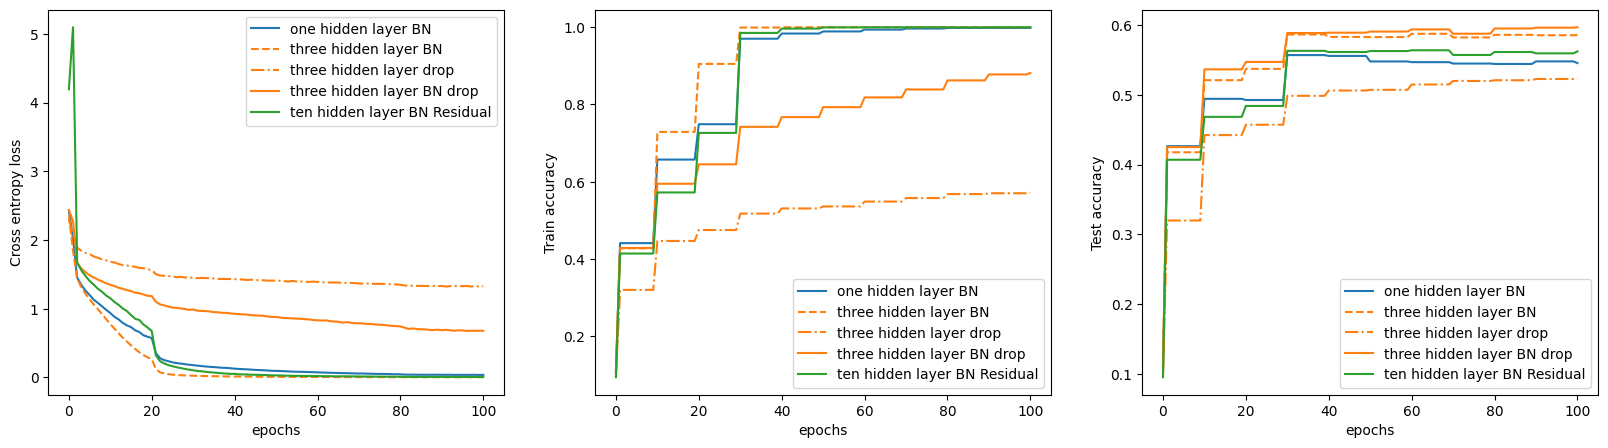

In [20]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))


## Plot cross entropy loss
ax11.plot(range(len(one_1024_bn_loss)), one_1024_bn_loss,label = 'one hidden layer BN', color = 'C0')
ax11.plot(range(len(three_1024_bn_loss)), three_1024_bn_loss,label = 'three hidden layer BN', color = 'C1', linestyle = "--")
ax11.plot(range(len(three_1024_drop05_loss)), three_1024_drop05_loss,label = 'three hidden layer drop', color = 'C1', linestyle = "-.")
ax11.plot(range(len(three_1024_bn_drop05_loss)), three_1024_bn_drop05_loss,label = 'three hidden layer BN drop', color = 'C1')
ax11.plot(range(len(ten_1024_bn_res_loss)), ten_1024_bn_res_loss,label = 'ten hidden layer BN Residual', color = 'C2')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(one_1024_bn_train_acc)), [_.cpu() for _ in one_1024_bn_train_acc],label = 'one hidden layer BN', color = 'C0')
ax21.plot(range(len(three_1024_bn_train_acc)), [_.cpu() for _ in three_1024_bn_train_acc],label = 'three hidden layer BN', color = 'C1', linestyle = "--")
ax21.plot(range(len(three_1024_drop05_train_acc)), [_.cpu() for _ in three_1024_drop05_train_acc ],label = 'three hidden layer drop', color = 'C1', linestyle = "-.")
ax21.plot(range(len(three_1024_bn_drop05_train_acc)), [_.cpu() for _ in three_1024_bn_drop05_train_acc ],label = 'three hidden layer BN drop', color = 'C1')
ax21.plot(range(len(ten_1024_bn_res_train_acc)),[_.cpu() for _ in ten_1024_bn_res_train_acc],label = 'ten hidden layer BN Residual', color = 'C2')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(one_1024_bn_test_acc)), [_.cpu() for _ in one_1024_bn_test_acc],label = 'one hidden layer BN', color = 'C0')
ax31.plot(range(len(three_1024_bn_test_acc)), [_.cpu() for _ in three_1024_bn_test_acc],label = 'three hidden layer BN', color = 'C1', linestyle = "--")
ax31.plot(range(len(three_1024_drop05_test_acc)), [_.cpu() for _ in three_1024_drop05_test_acc] ,label = 'three hidden layer drop', color = 'C1', linestyle = "-.")
ax31.plot(range(len(three_1024_bn_drop05_test_acc)), [_.cpu() for _ in three_1024_bn_drop05_test_acc],label = 'three hidden layer BN drop', color = 'C1')
ax31.plot(range(len(ten_1024_bn_res_test_acc)), [_.cpu() for _ in ten_1024_bn_res_test_acc],label = 'ten hidden layer BN Residual', color = 'C2')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### 3.2 Revisiting Overfitting (CIFAR100)

Since the effect is not present in CIFAR10, let's repeat with CIFAR100.

## TODO:

* Inspecting initialization. Show that relu are initialized with everything to zeros and how residual and BN solves this.
* Visualize gradients and activations.
* Obtain a baseline over mnist using a linear model.
* Visualize sensitivity to model initialization.
* Train models on cifar100